In [44]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import folium
from folium.plugins import MarkerCluster

data = pd.read_csv('cloud-data/bus_data_modified.csv')
# convert timestamp to datetime
data['timestamp'] = pd.to_datetime(data['timestamp'])
# shift all timestamps 6 hrs back
data['timestamp'] = data['timestamp'] - pd.Timedelta(hours=4)
# only use the latitude and longitude columns between certain values
data = data[(data['latitude'] > 40.4) & (data['latitude'] < 40.53)]
data = data[(data['longitude'] > -74.5) & (data['longitude'] < -74.3)]
data.head()

id  name                   type  calculatedCourse   routeName   created  \
0   4855  4131            Transit Bus        212.735226    LX Route  02:23 PM   
1   4859  4177            Transit Bus        128.232575    LX Route  02:23 PM   
2   4873  4191            Transit Bus        240.802514     B Route  02:23 PM   
3   4876  4194            Transit Bus        299.246496     B Route  02:23 PM   
4  17624  4002  Heavy Duty Transit LF        226.694476  REXB Route  02:23 PM   

   longitude   latitude  paxLoad  totalCap  more  deviceId  routeBlockId  \
0 -74.433571  40.519749        0        67   101    402213        111417   
1 -74.436304  40.524327       27        67   102    402325        111417   
2 -74.457712  40.523463        8        67   101    402329        113278   
3 -74.438946  40.521624        4        67   102    402330        113250   
4 -74.438830  40.483538        2        68   102    402643        112511   

            timestamp      load                       stop  
0 2024-10-31 14:24:00  0.000000                      Quads  
1 2024-10-31 14:24:00  0.402985  Livingston Student Center  
2 2024-10-31 14:24:00  0.119403                        NaN  
3 2024-10-31 14:24:00  0.059701                        NaN  
4 2024-10-31 14:24:00  0.029412                        NaN

In [45]:
def get_home_stop(stops):
    for stop in stops:
        if 'student center' in stop.lower():
            return stop
        
    return stops[0]

In [46]:
# create a data frame with unique timestamps as index and columns with the number of buses on a given route at the stop
route = 'LX Route'
data_route = data[data['routeName'] == route]

stops = data_route['stop'].unique()

timestamps = data_route['timestamp'].unique()

# convert timestamps to dataframe with stops as columns
df = pd.DataFrame(index=timestamps, columns=stops)
df.head()

Quads Livingston Student Center  NaN  \
2024-10-31 14:24:00   NaN                       NaN  NaN   
2024-10-31 14:24:31   NaN                       NaN  NaN   
2024-10-31 14:25:01   NaN                       NaN  NaN   
2024-10-31 14:25:32   NaN                       NaN  NaN   
2024-10-31 14:26:02   NaN                       NaN  NaN   

                    College Avenue Student Center  \
2024-10-31 14:24:00                           NaN   
2024-10-31 14:24:31                           NaN   
2024-10-31 14:25:01                           NaN   
2024-10-31 14:25:32                           NaN   
2024-10-31 14:26:02                           NaN   

                    Student Activities Center (NB) The Yard Livingston Plaza  
2024-10-31 14:24:00                            NaN      NaN              NaN  
2024-10-31 14:24:31                            NaN      NaN              NaN  
2024-10-31 14:25:01                            NaN      NaN              NaN  
2024-10-31 14:25:32                            NaN      NaN              NaN  
2024-10-31 14:26:02                            NaN      NaN              NaN

In [48]:
# Initialize the resulting DataFrame
result_columns = ['bus_id', 'timestamp', 'load', 'stop', 'time_on_route', 'time_waiting']
result_data = []

start_stop = get_home_stop(data['stop'].unique())

# Process each bus on the route
for bus_id in data_route['id'].unique():
    data_bus = data_route[data_route['id'] == bus_id].copy()

    if len(data_bus) <= 20: # Skip buses with less than 20 records
        continue

    # Initialize columns for time calculations
    data_bus['time_to_complete'] = 0
    data_bus['time_waiting'] = 0

    for i in range(1, len(data_bus)):
        time_diff = (data_bus['timestamp'].iloc[i] - data_bus['timestamp'].iloc[i - 1]).seconds

        if data_bus['stop'].iloc[i] != start_stop:
            data_bus.loc[data_bus.index[i], 'time_to_complete'] = (
                data_bus['time_to_complete'].iloc[i - 1] + time_diff
            )
            data_bus.loc[data_bus.index[i], 'time_waiting'] = 0
        else:
            data_bus.loc[data_bus.index[i], 'time_waiting'] = (
                data_bus['time_waiting'].iloc[i - 1] + time_diff
            )
            data_bus.loc[data_bus.index[i], 'time_to_complete'] = 0

        if time_diff > 300:  # Reset if time difference > 5 minutes
            data_bus.loc[data_bus.index[i], ['time_to_complete', 'time_waiting']] = 0

    # Aggregate data for the bus
    for i, row in data_bus.iterrows():
        result_data.append([
            bus_id,
            row['timestamp'],
            row['load'],
            row['stop'],
            row['time_to_complete'],
            row['time_waiting'],
        ])

# Combine all buses into a single DataFrame
result_df = pd.DataFrame(result_data, columns=result_columns)

# Display the first few rows of the combined DataFrame
result_df.head()

bus_id           timestamp  load   stop  time_on_route  time_waiting
0    4855 2024-10-31 14:24:00   0.0  Quads              0             0
1    4855 2024-10-31 14:24:31   0.0  Quads             31             0
2    4855 2024-10-31 14:25:01   0.0  Quads             61             0
3    4855 2024-10-31 14:25:32   0.0  Quads             92             0
4    4855 2024-10-31 14:26:02   0.0  Quads            122             0

In [49]:
result_df.to_csv(f'output/{route.replace(" ", "_")}_stop.csv', index=False)

In [50]:
result_df.describe()

bus_id                      timestamp          load  \
count  74321.000000                          74321  74321.000000   
mean    8582.243579  2024-11-04 16:13:24.713566976      0.317357   
min     4843.000000            2024-10-31 14:24:00      0.000000   
25%     4864.000000            2024-11-01 20:10:03      0.074627   
50%     4881.000000            2024-11-05 10:46:49      0.223881   
75%    13211.000000            2024-11-06 14:30:08      0.462687   
max    18020.000000            2024-11-07 17:51:49      1.000000   
std     4506.659399                            NaN      0.300727   

       time_on_route  time_waiting  
count   74321.000000  74321.000000  
mean      845.742549     27.332477  
min         0.000000      0.000000  
25%       281.000000      0.000000  
50%       786.000000      0.000000  
75%      1308.000000      0.000000  
max      4196.000000   1897.000000  
std       651.549325    109.792922

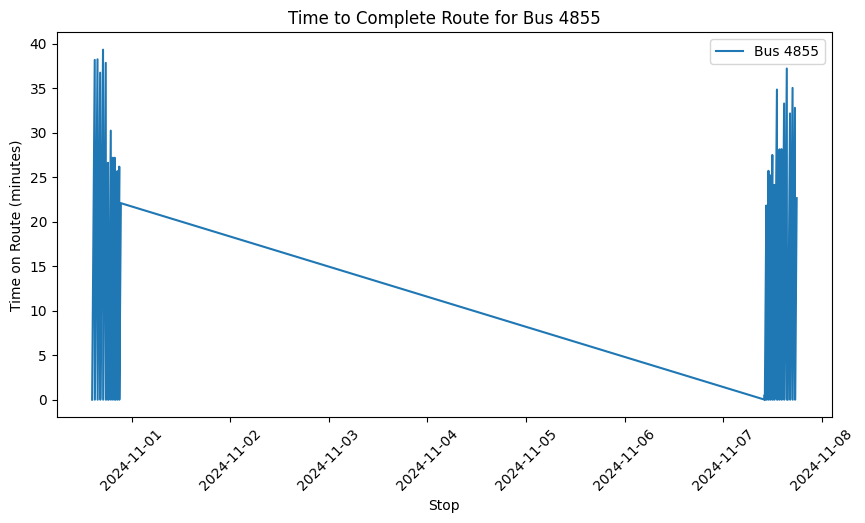

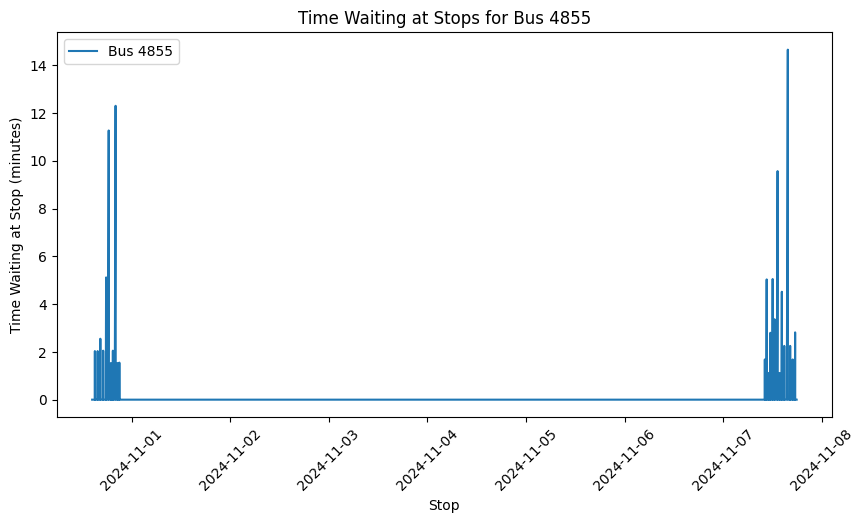

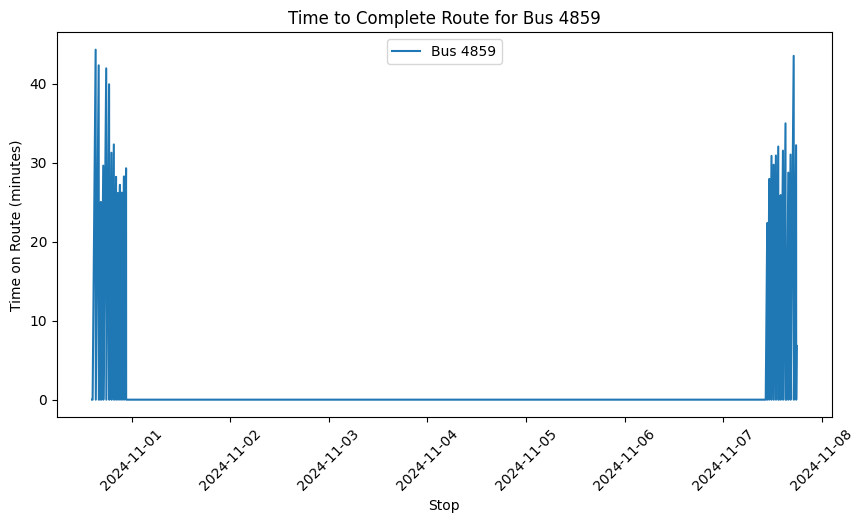

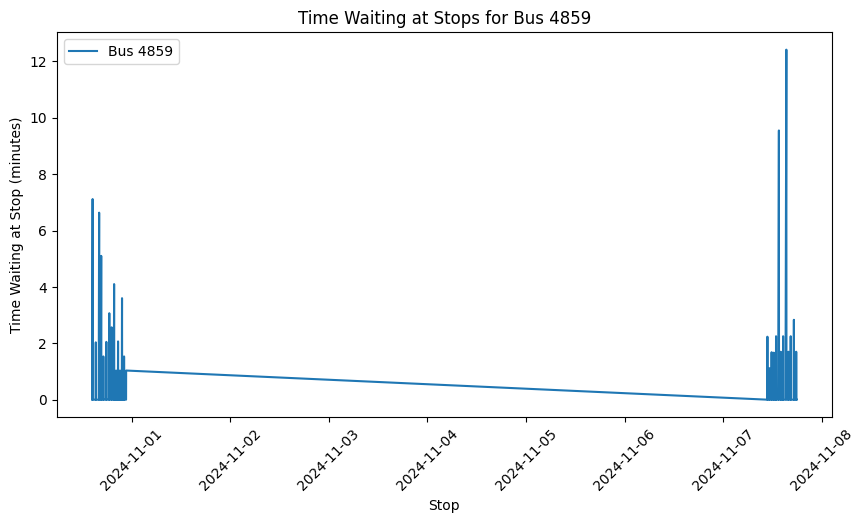

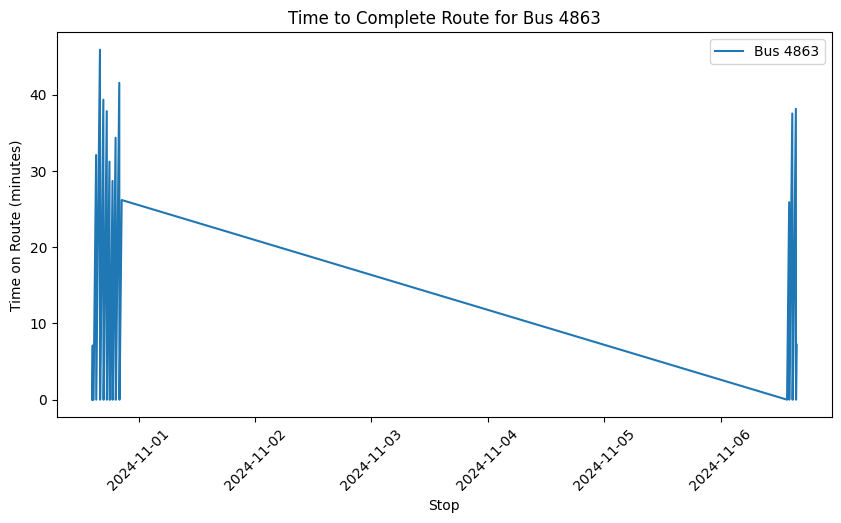

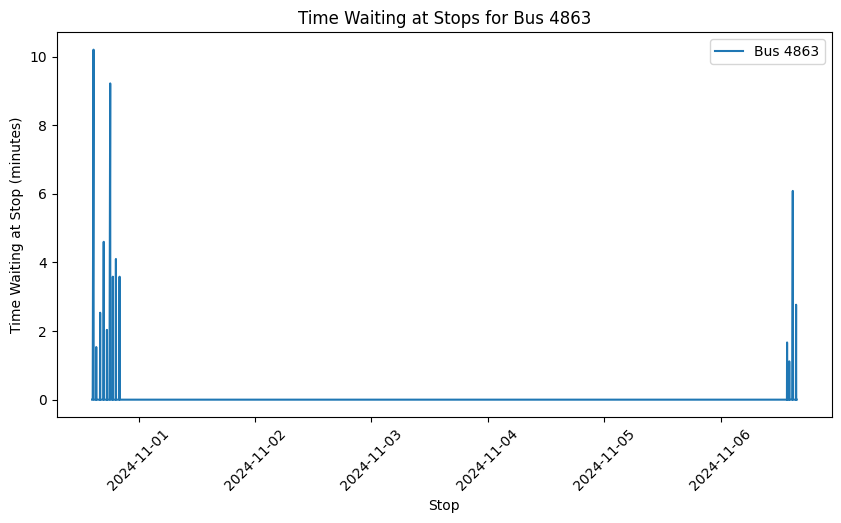

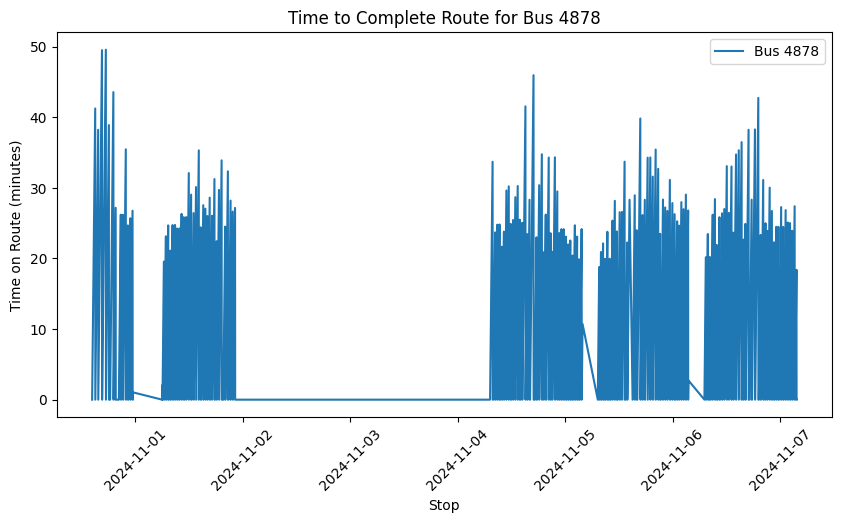

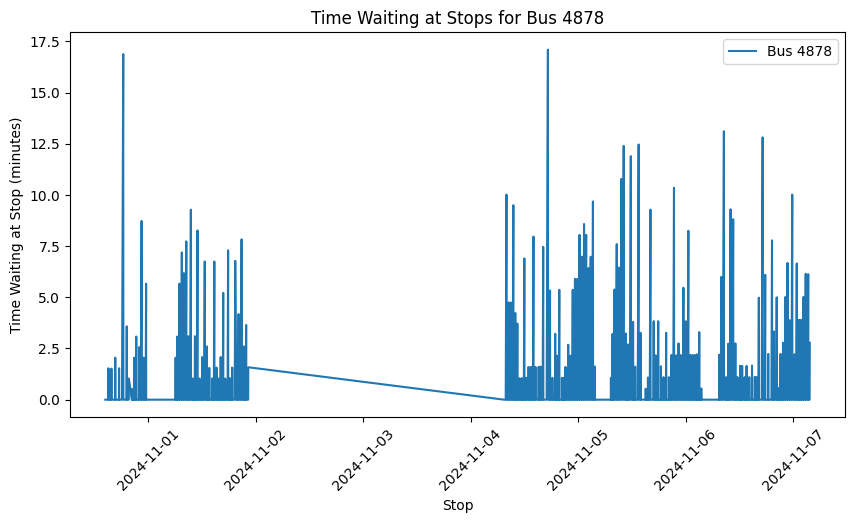

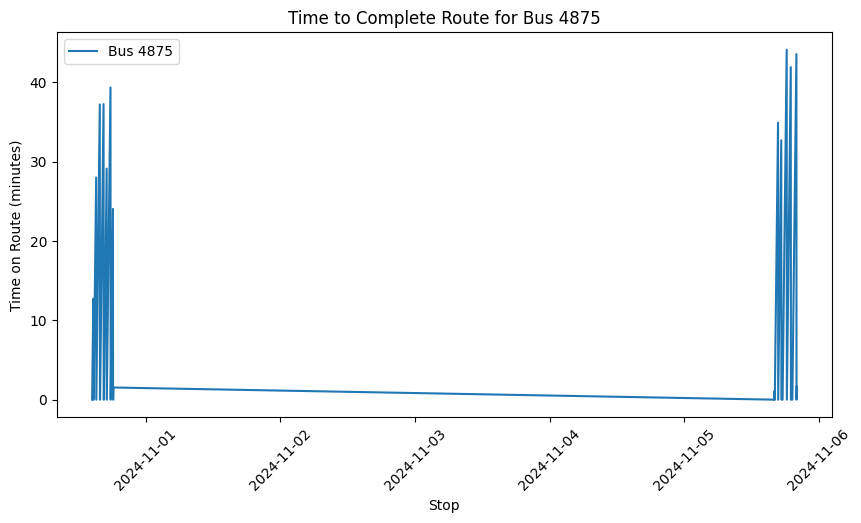

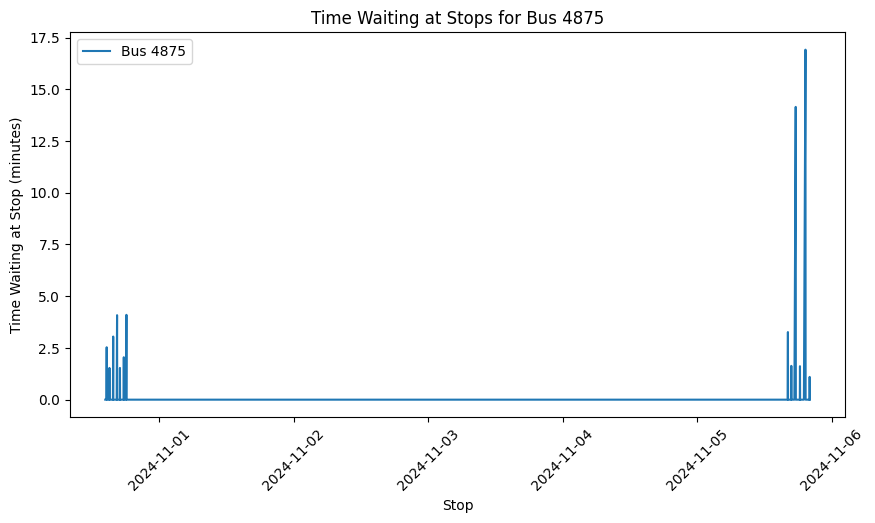

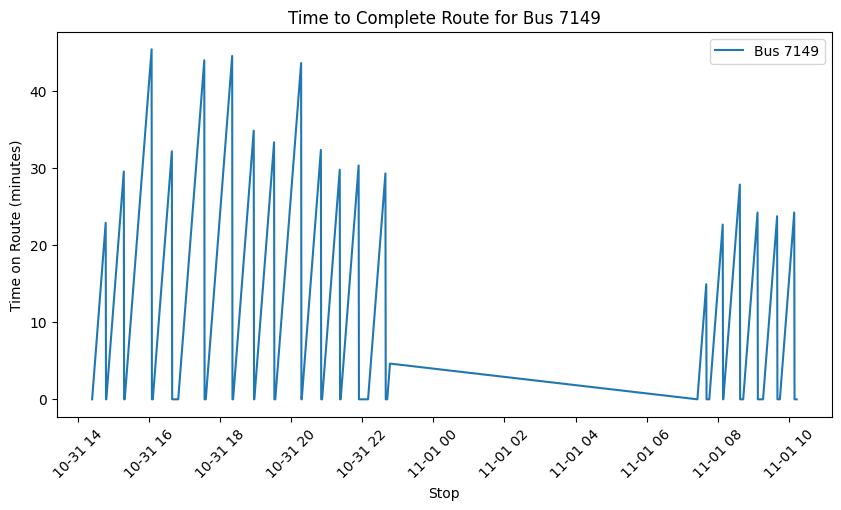

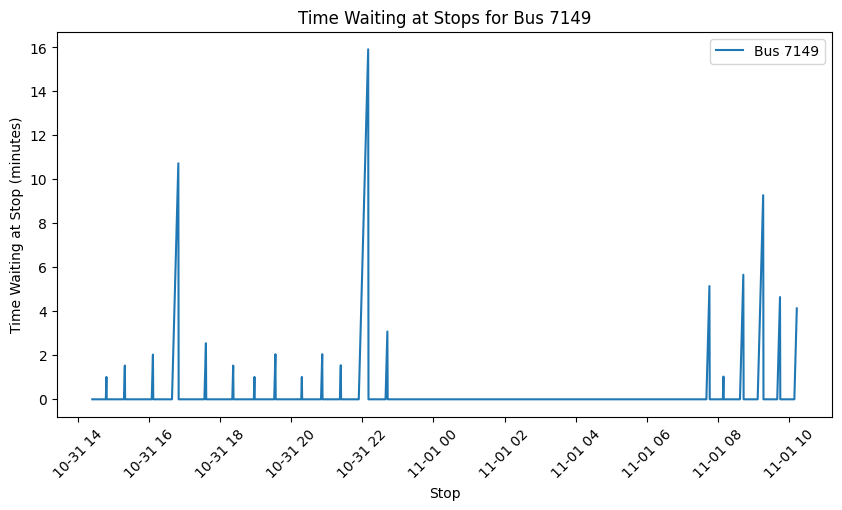

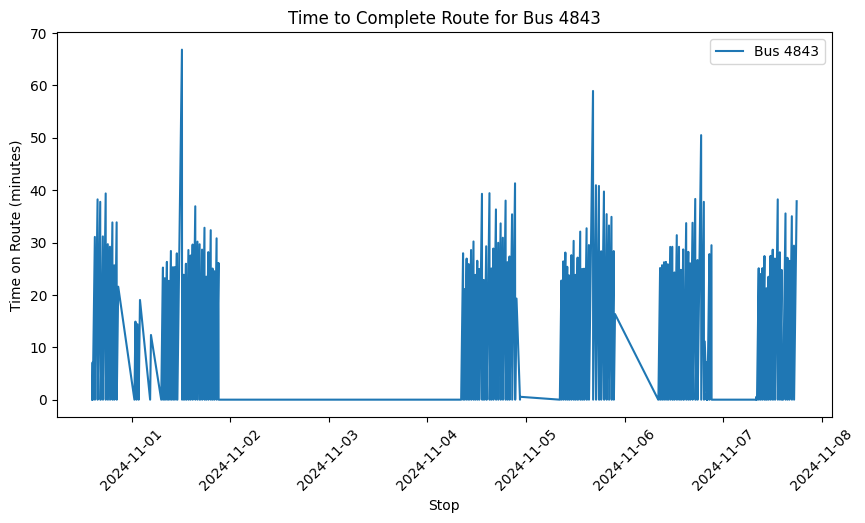

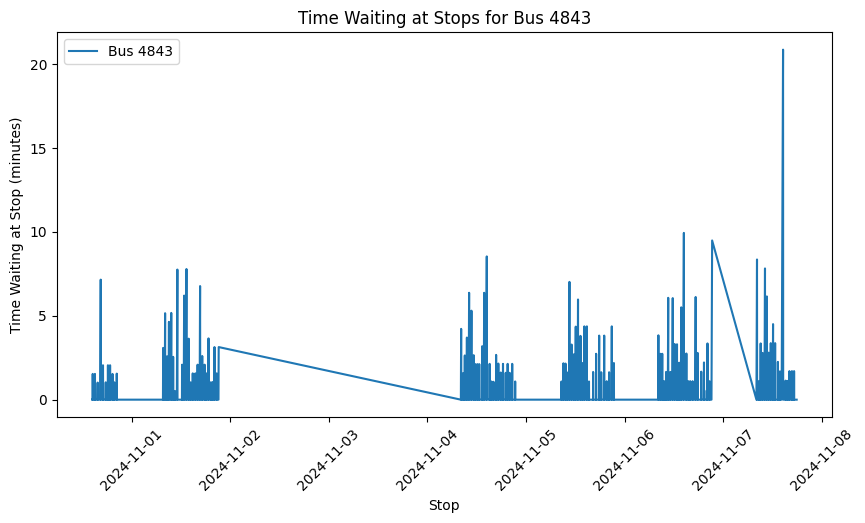

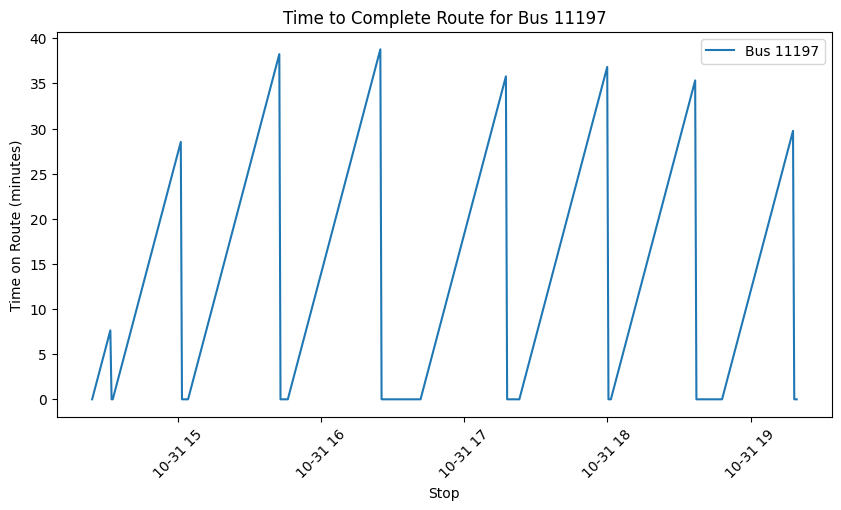

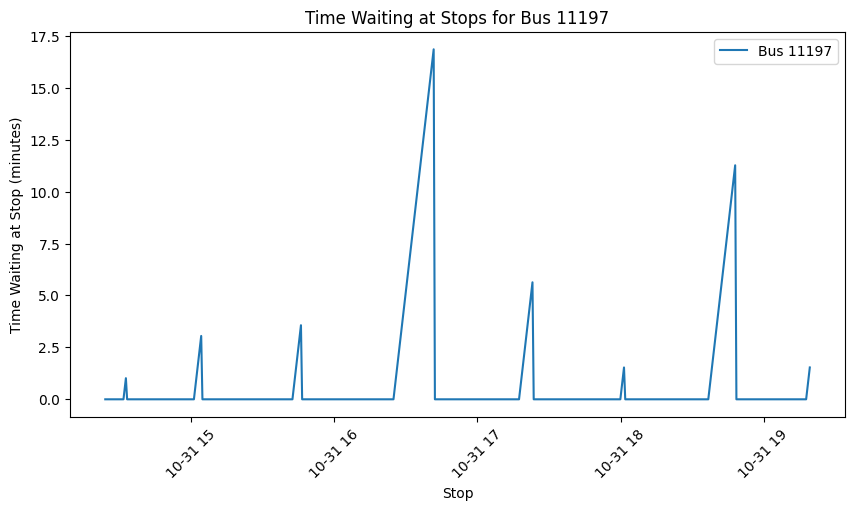

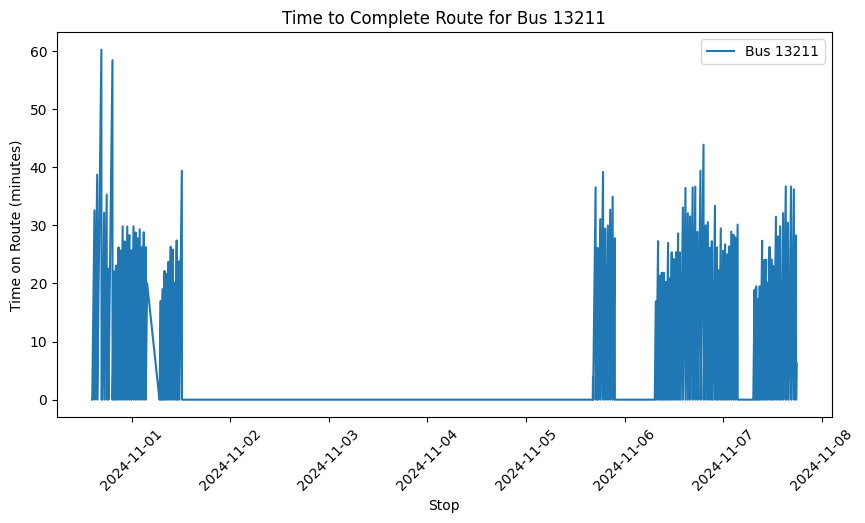

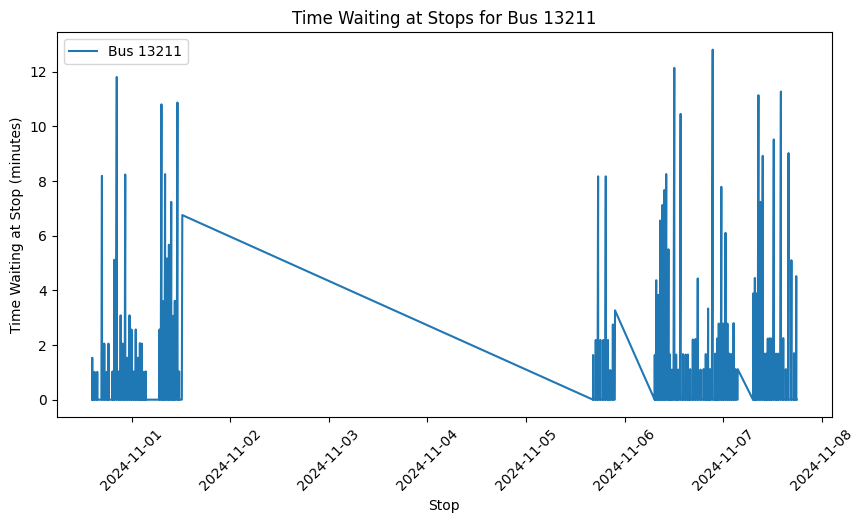

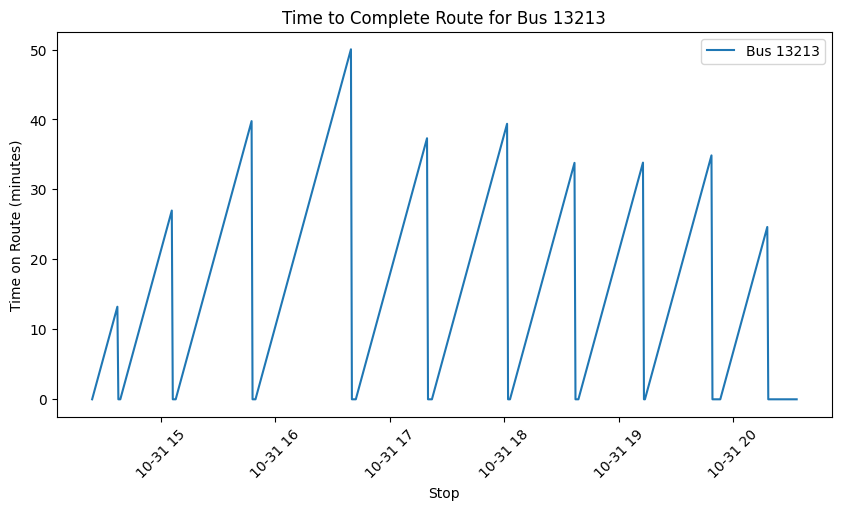

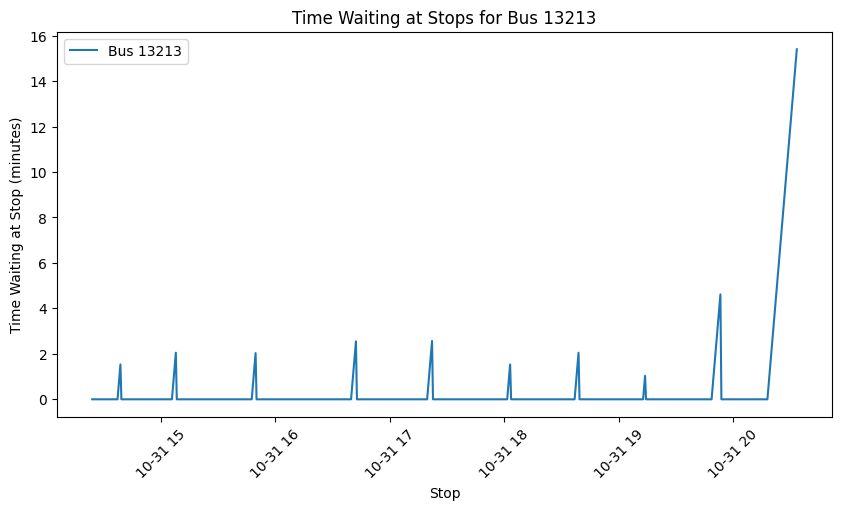

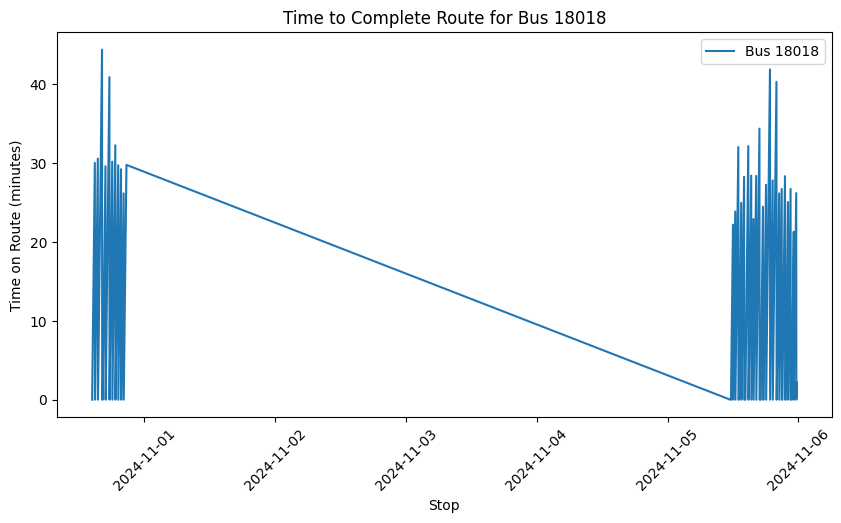

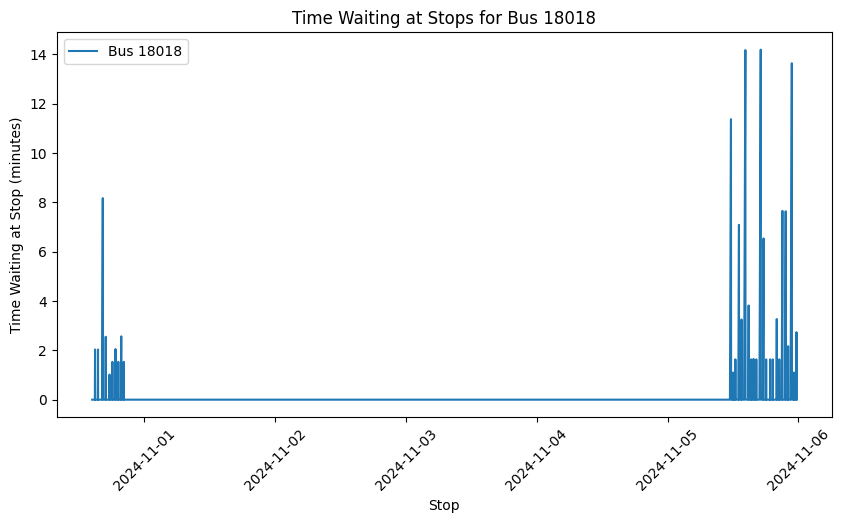

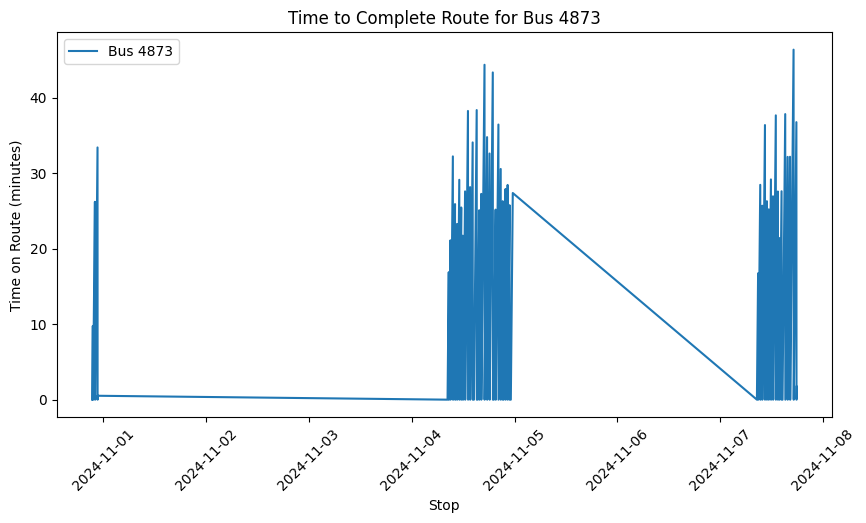

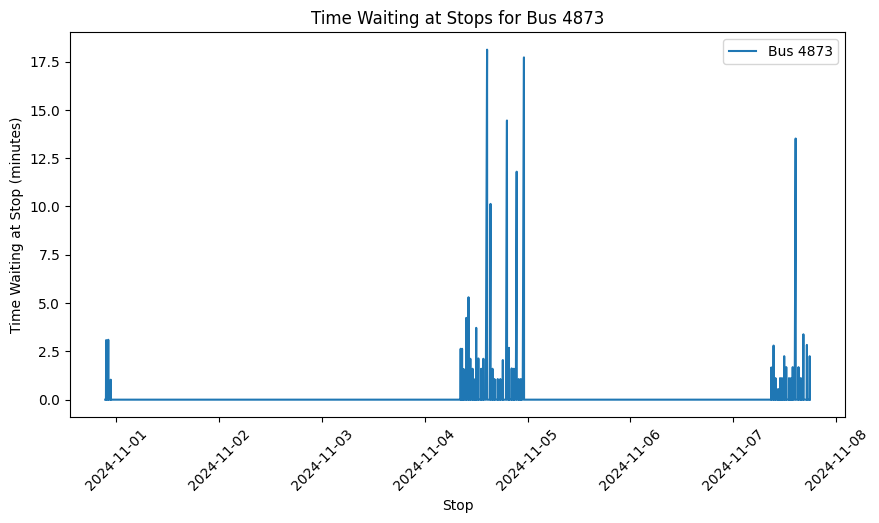

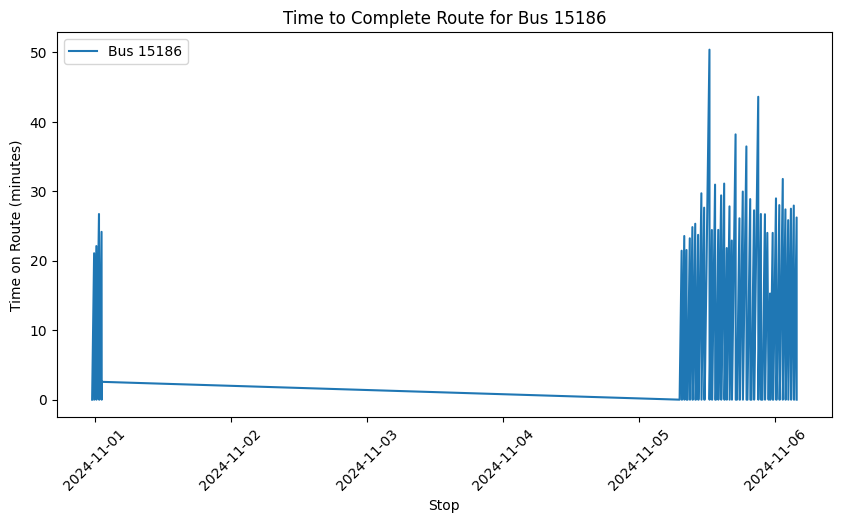

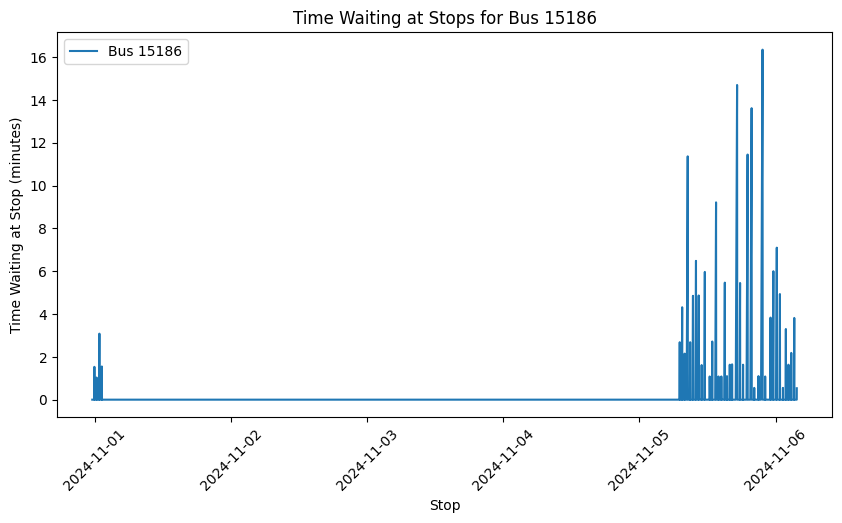

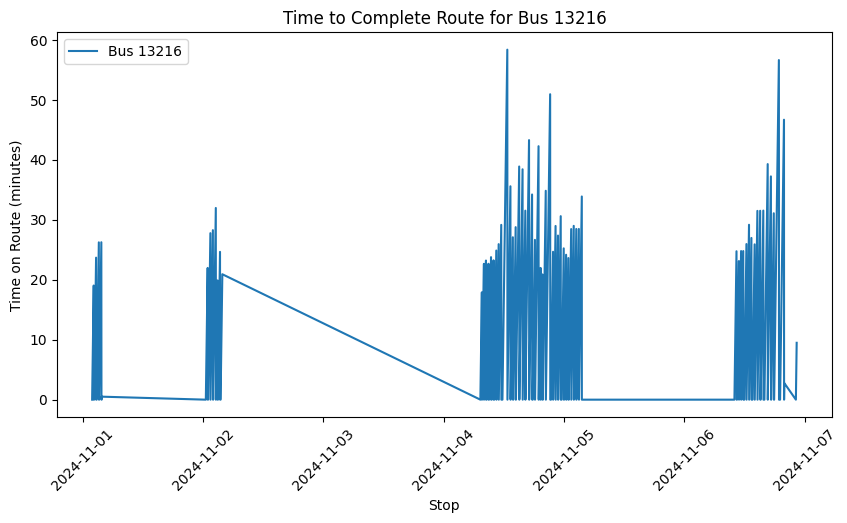

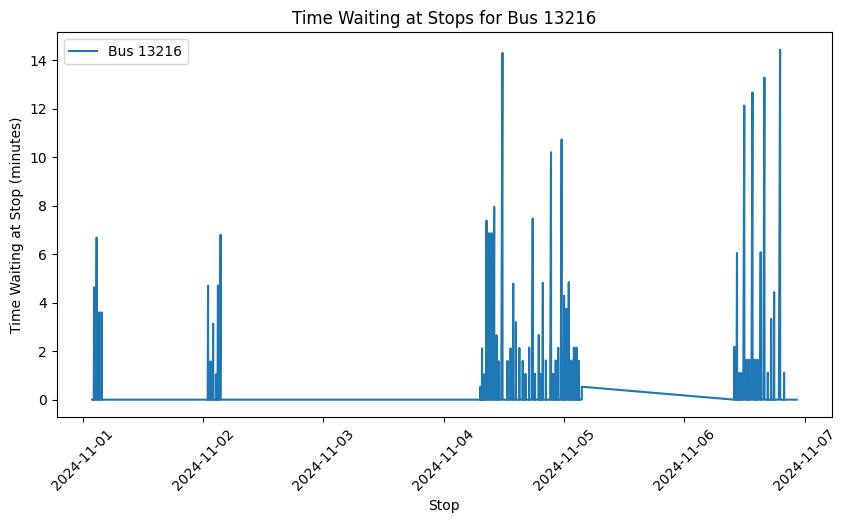

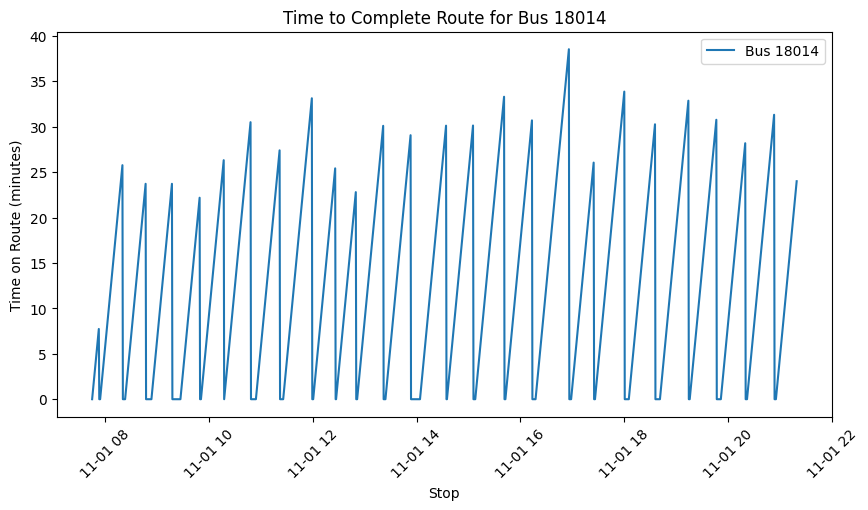

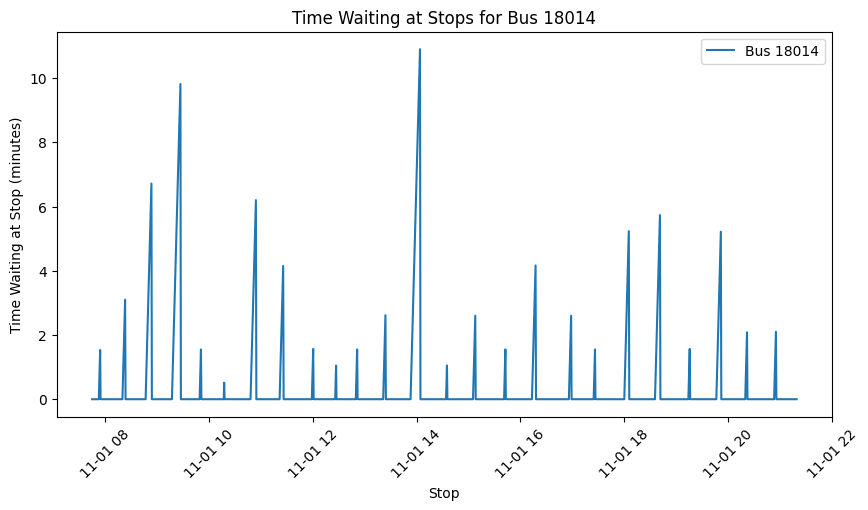

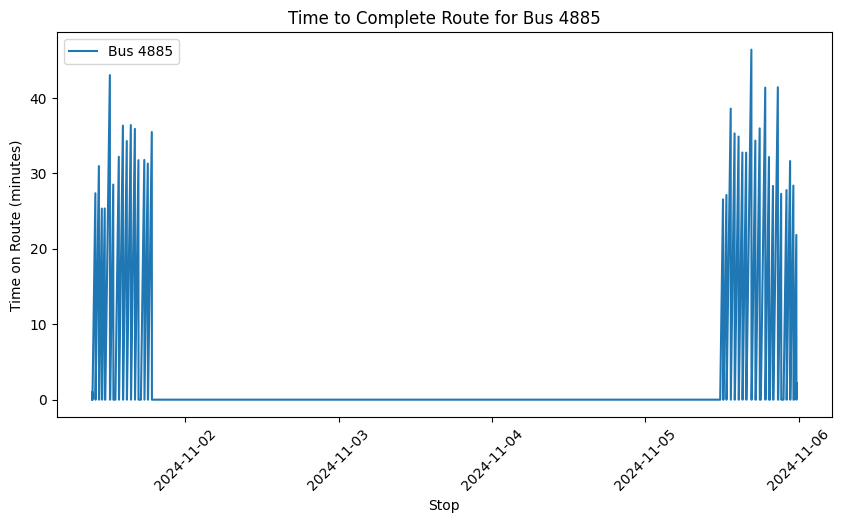

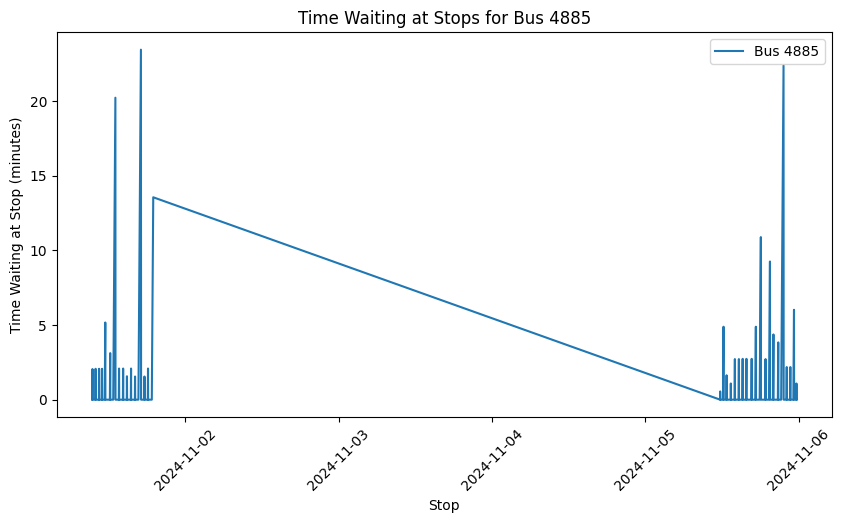

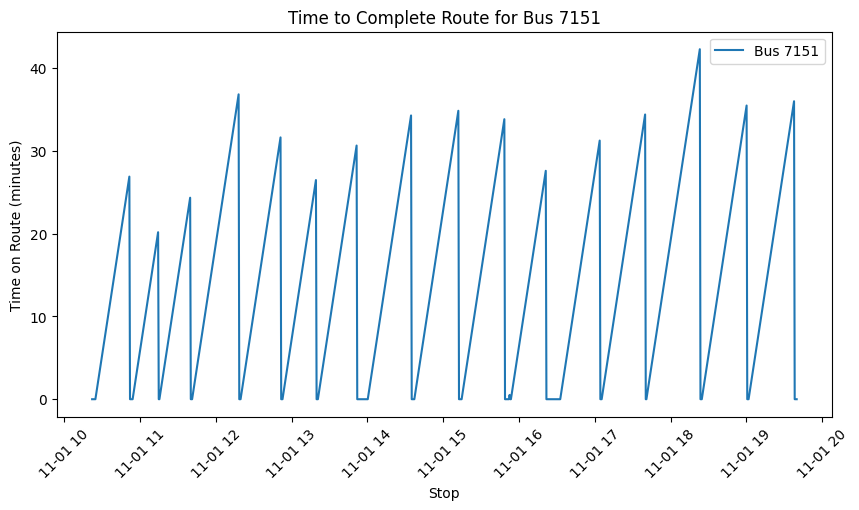

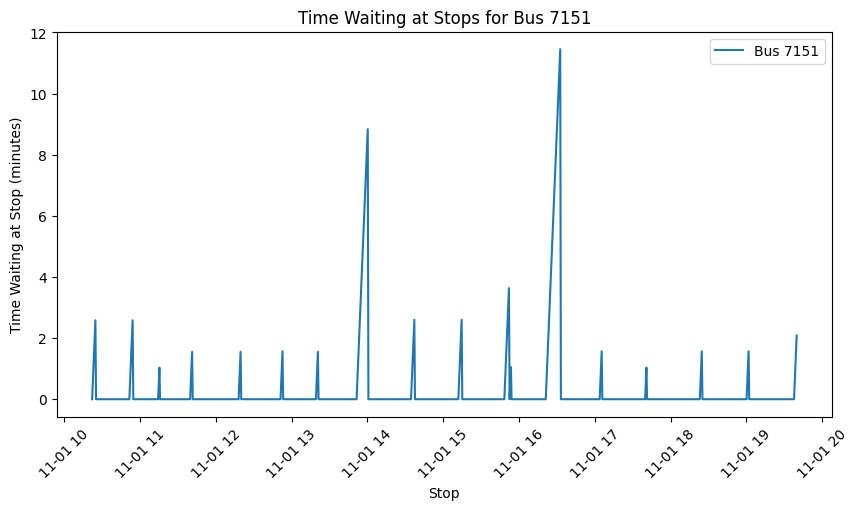

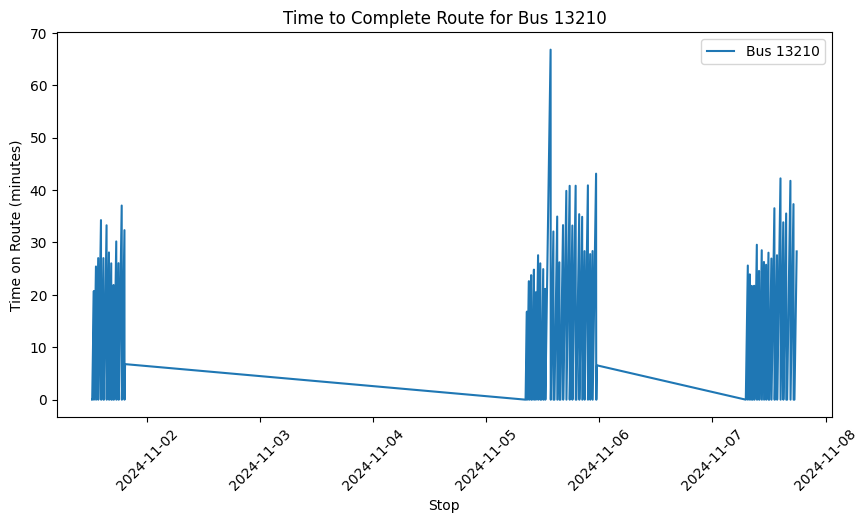

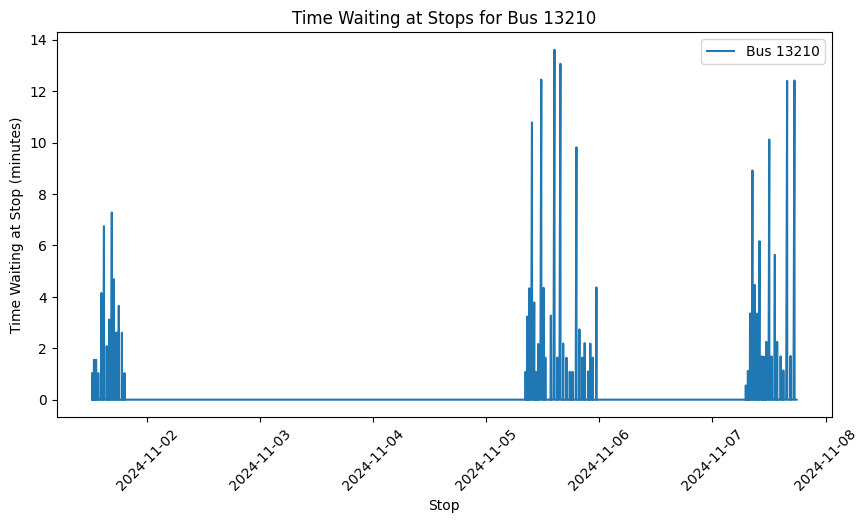

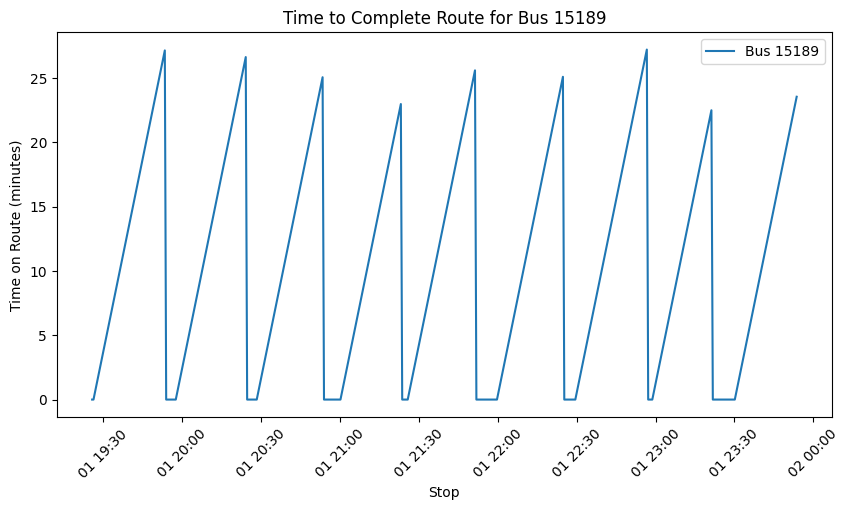

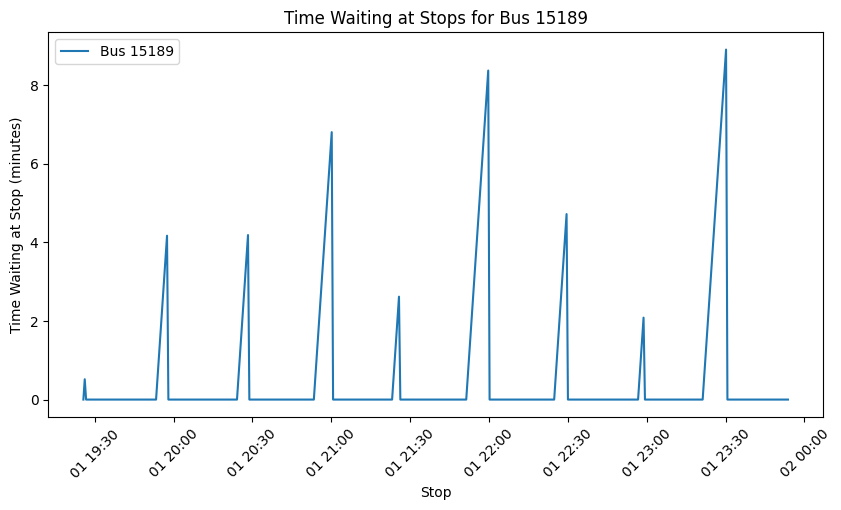

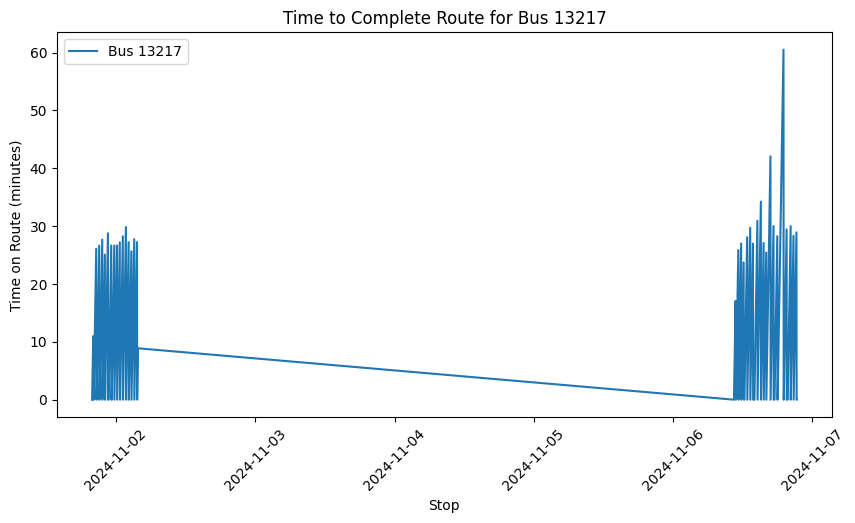

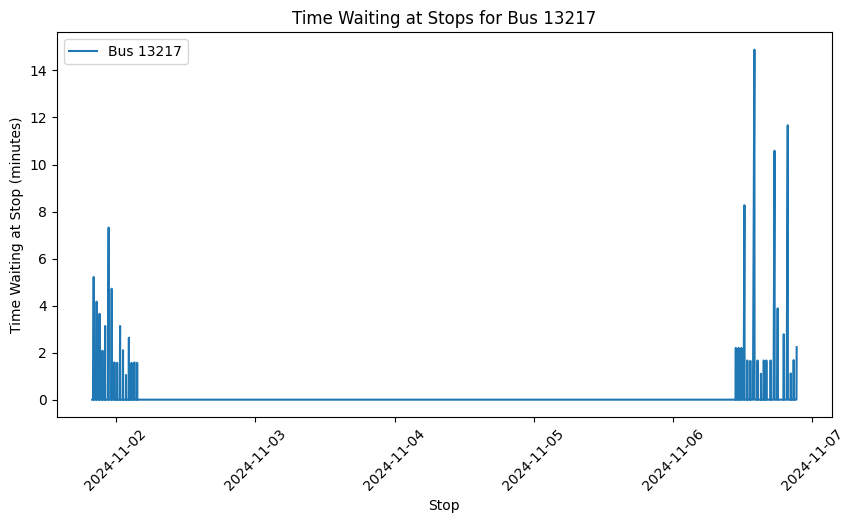

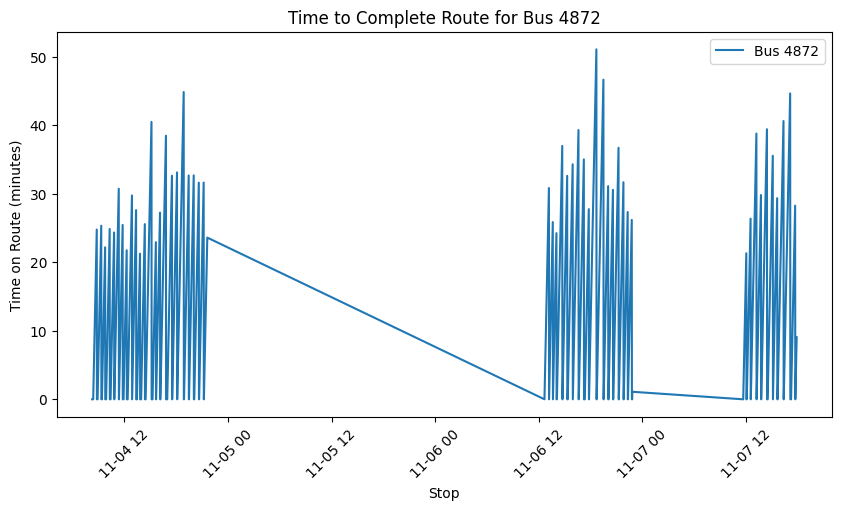

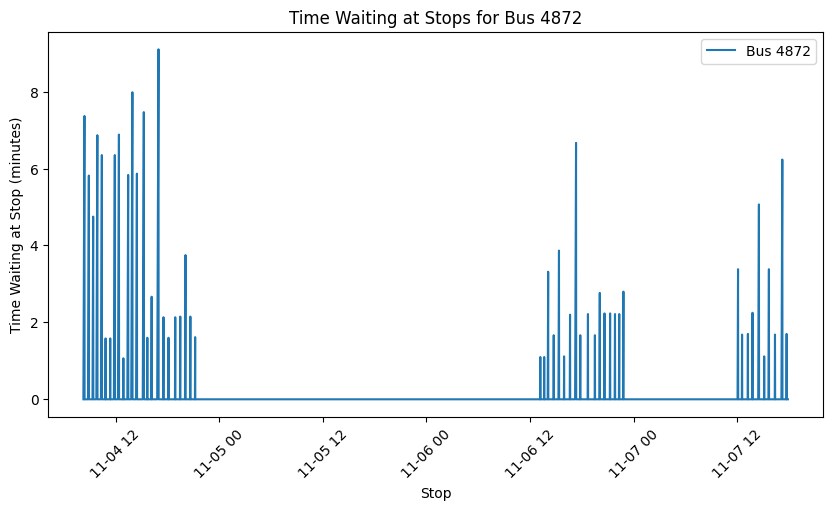

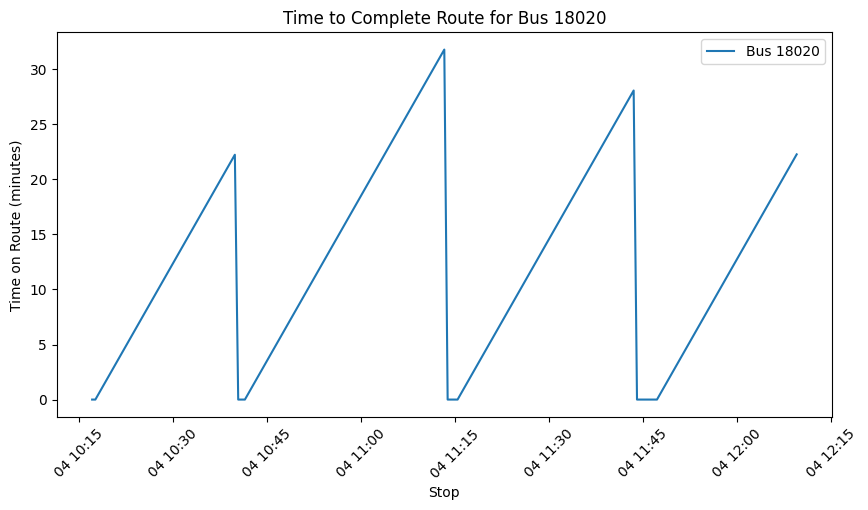

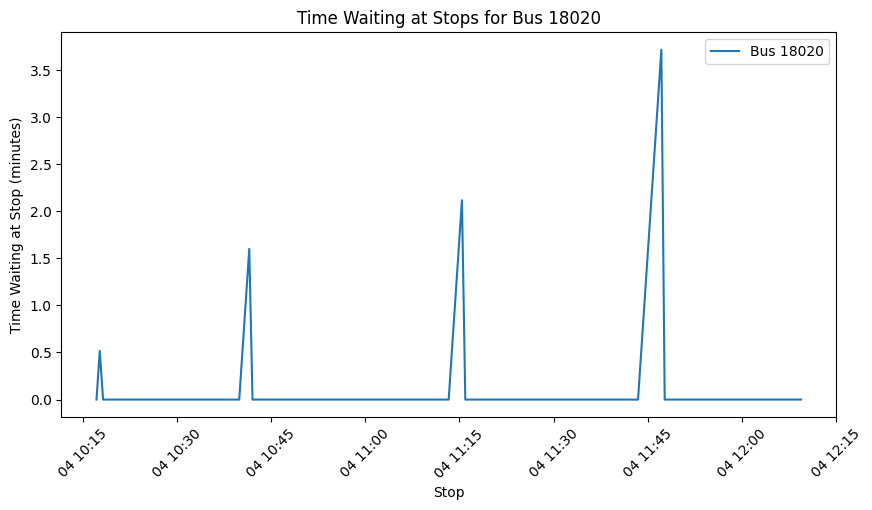

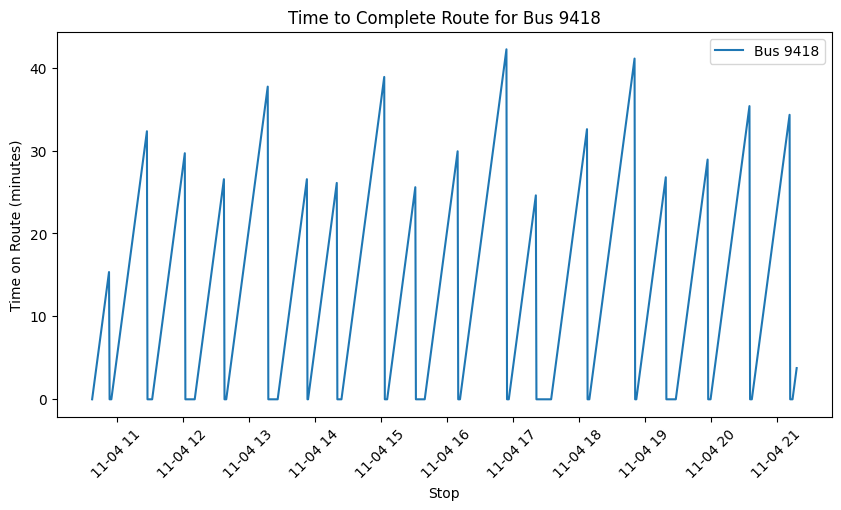

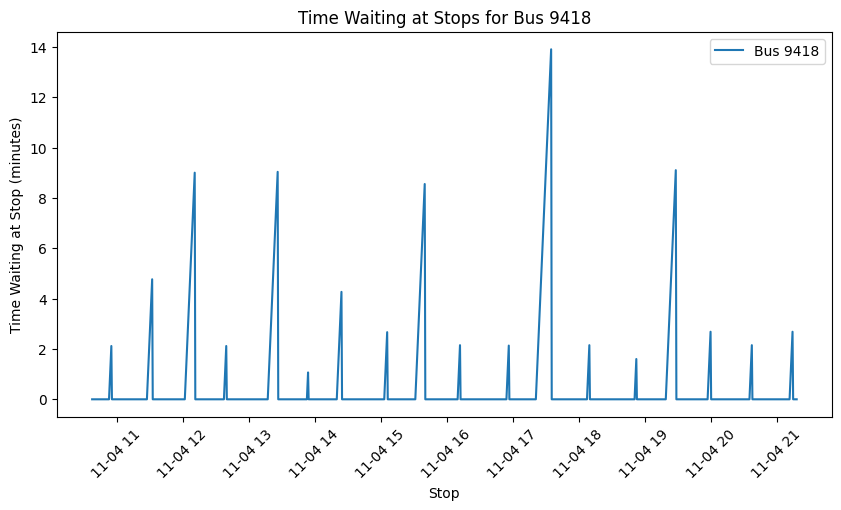

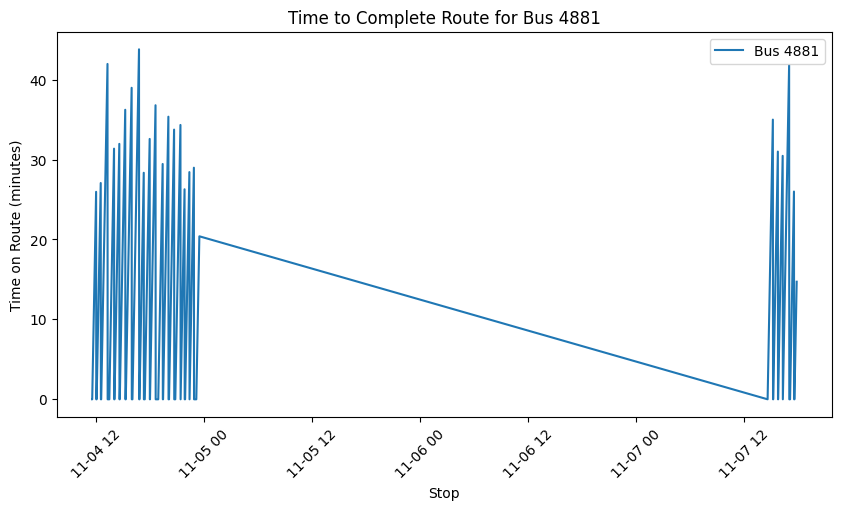

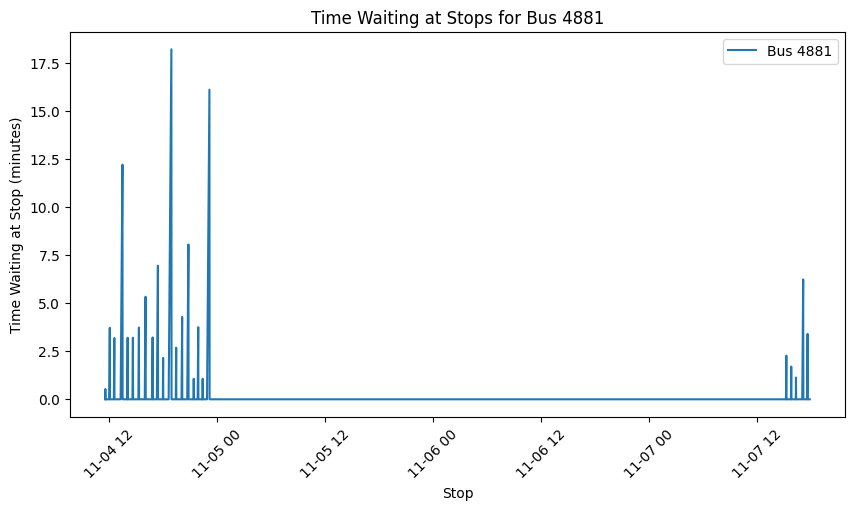

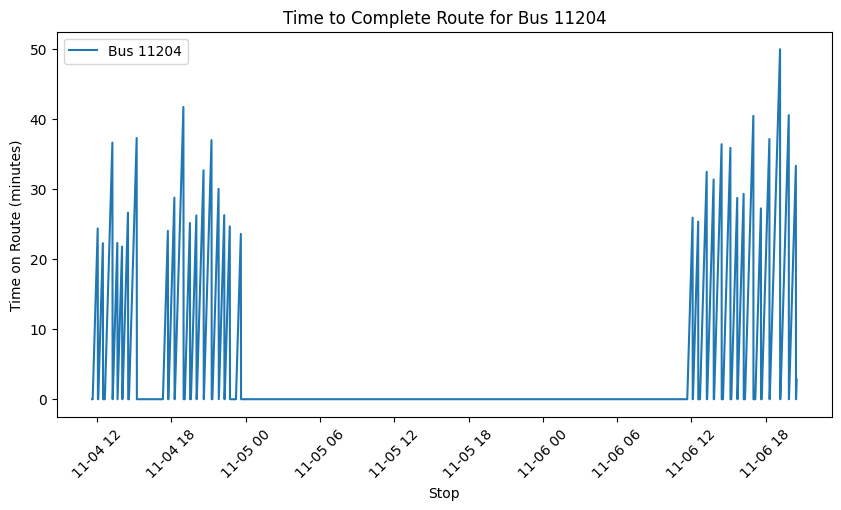

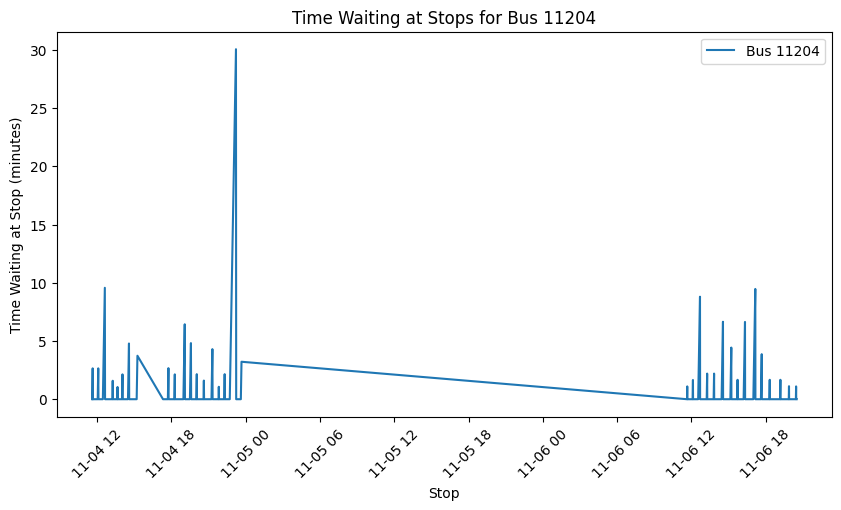

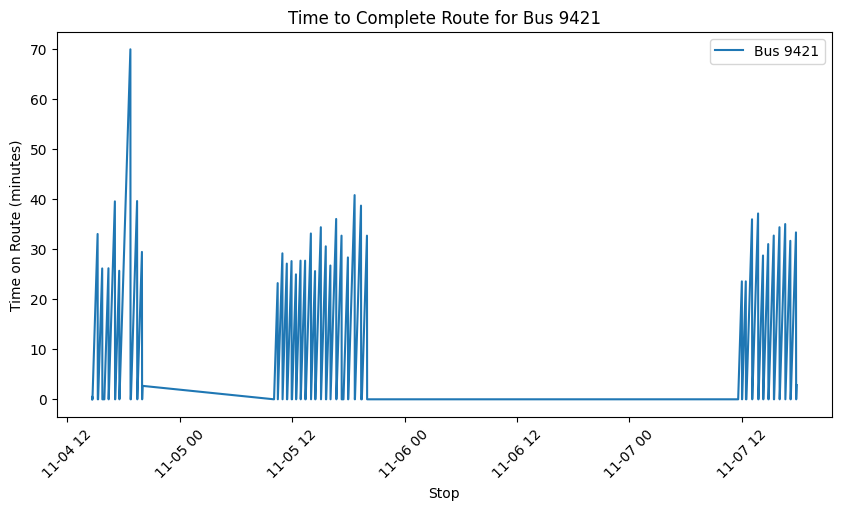

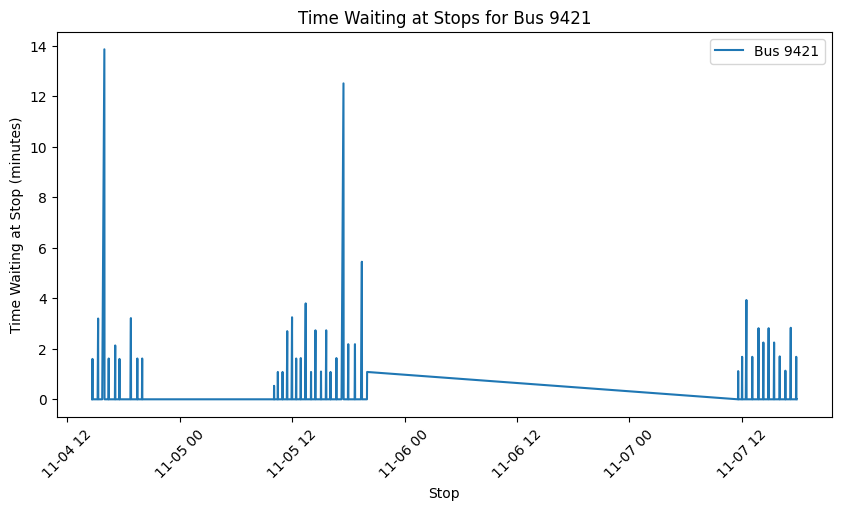

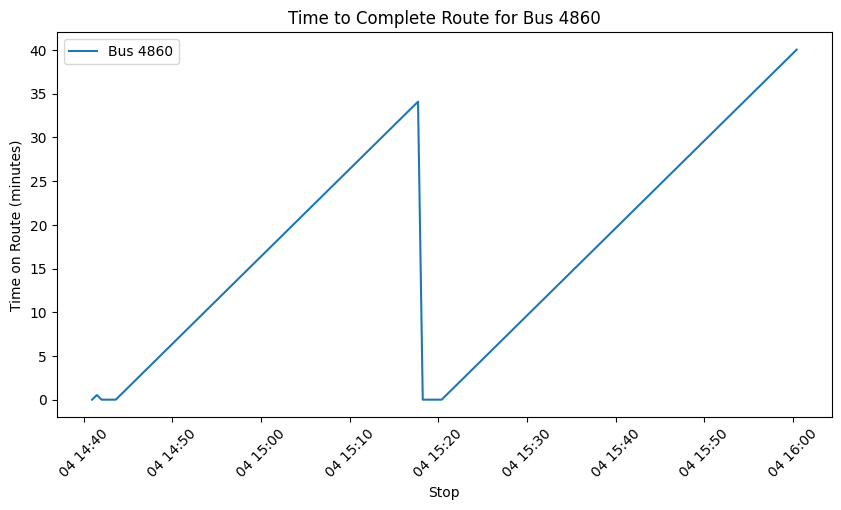

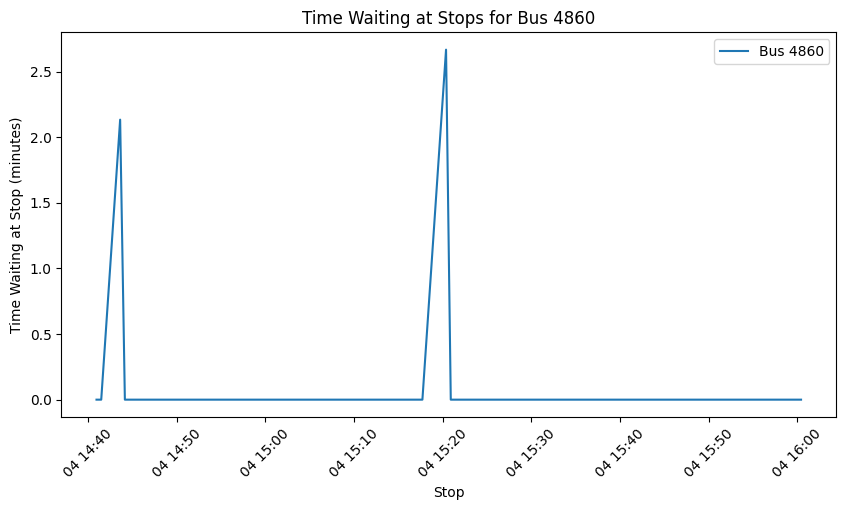

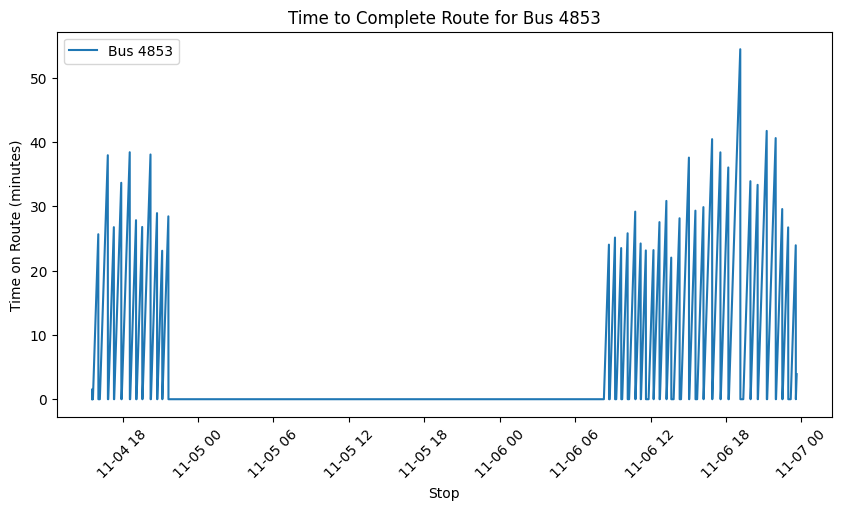

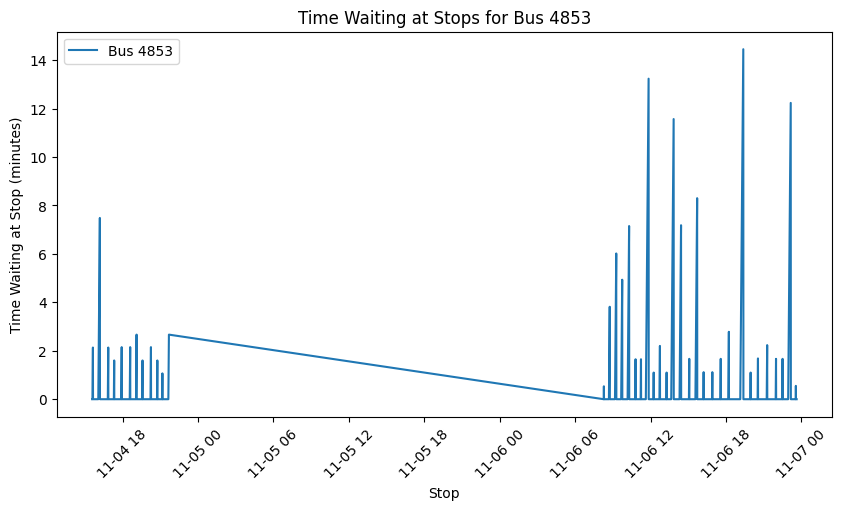

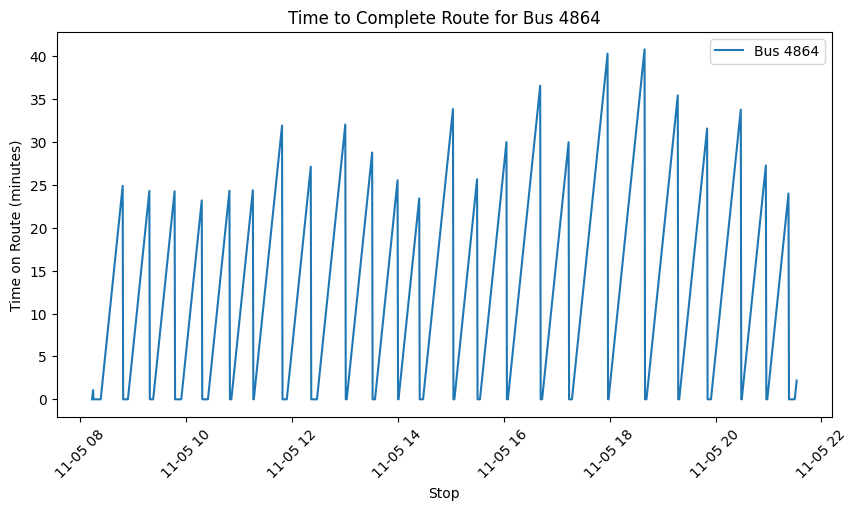

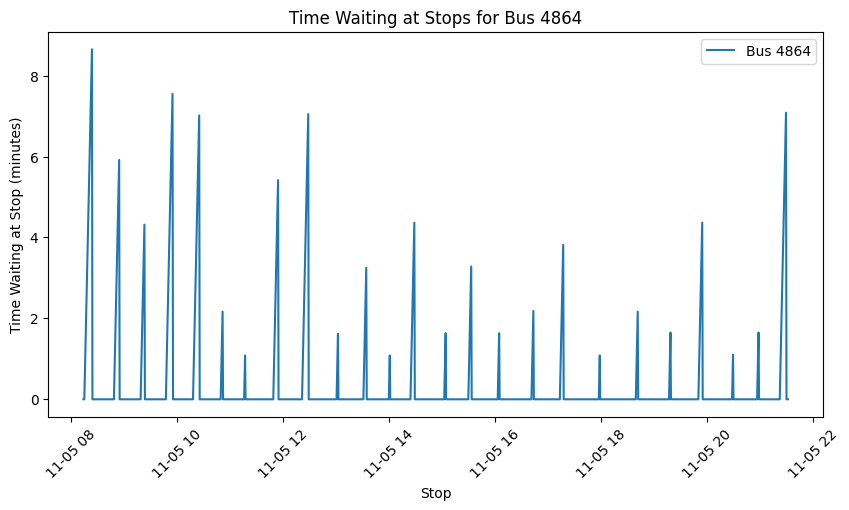

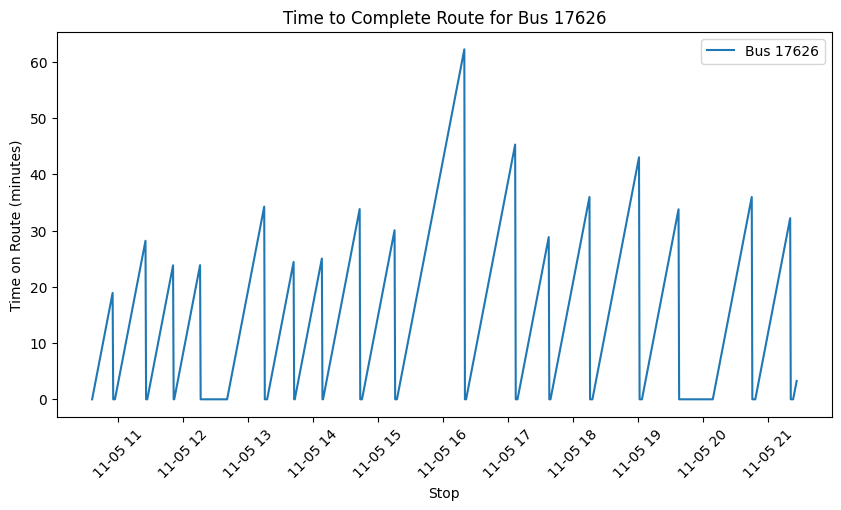

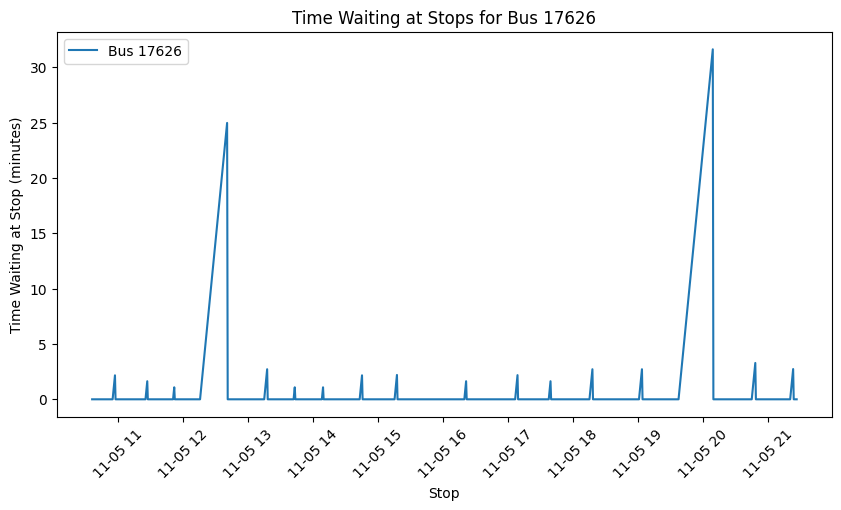

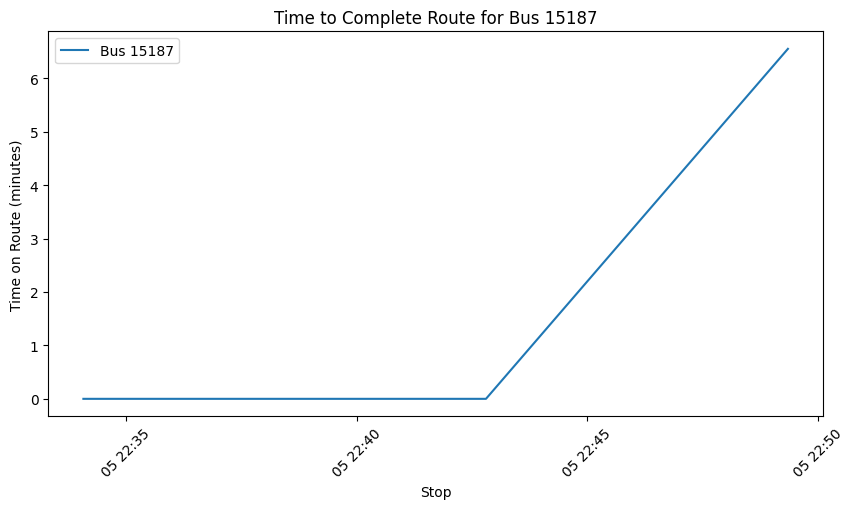

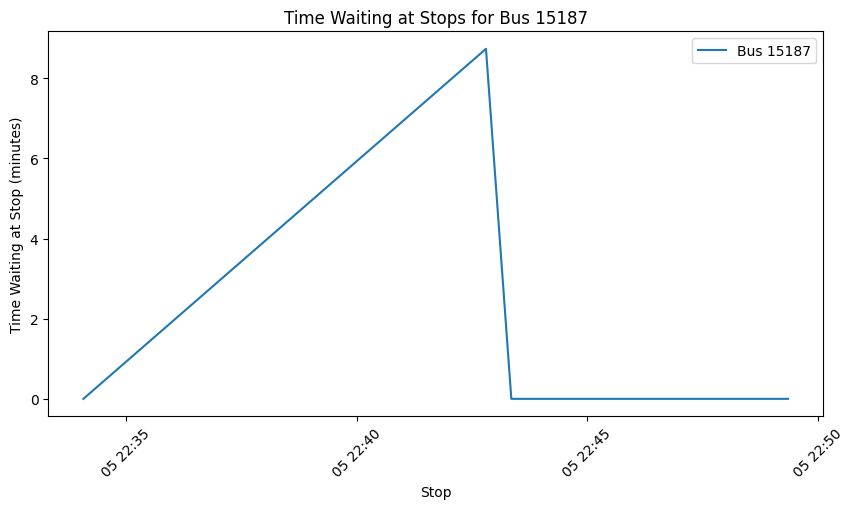

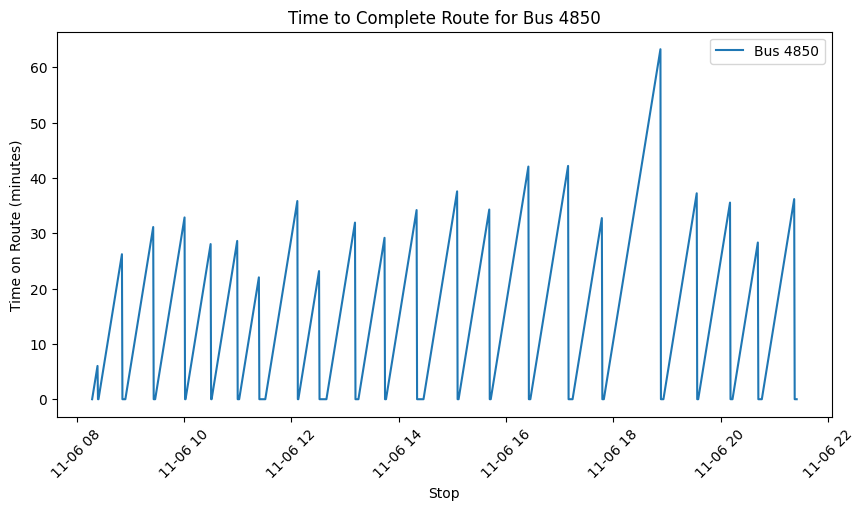

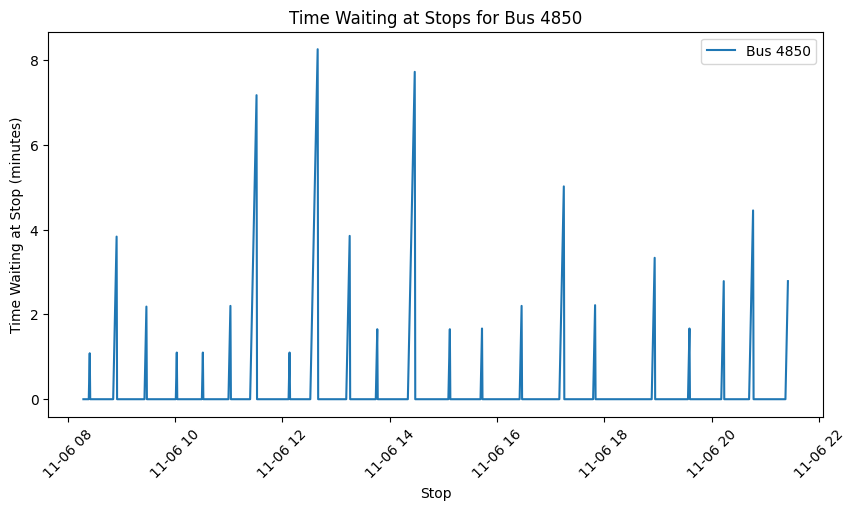

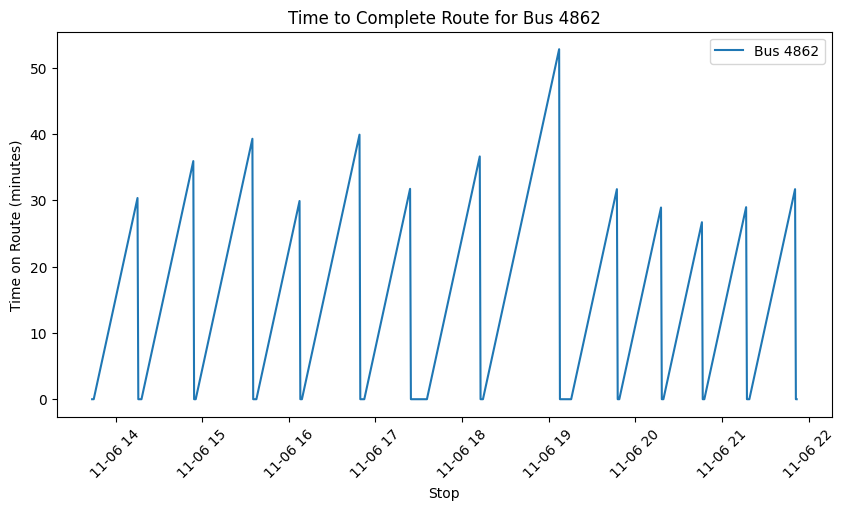

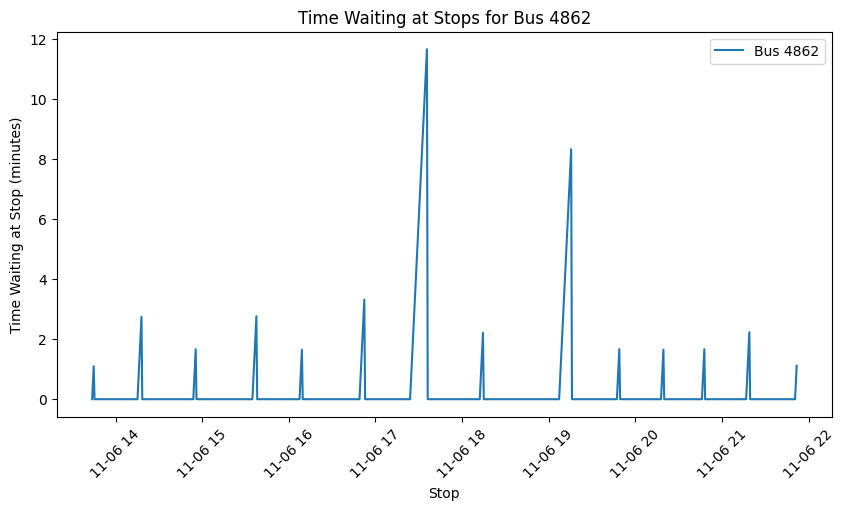

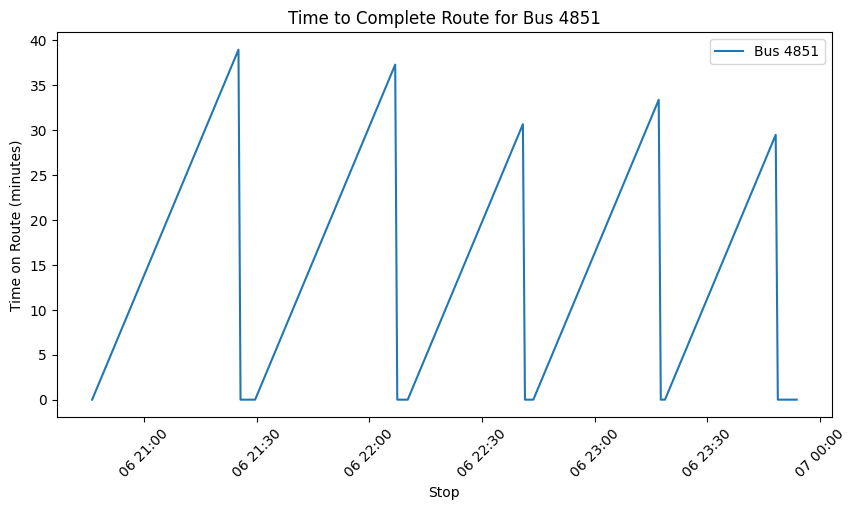

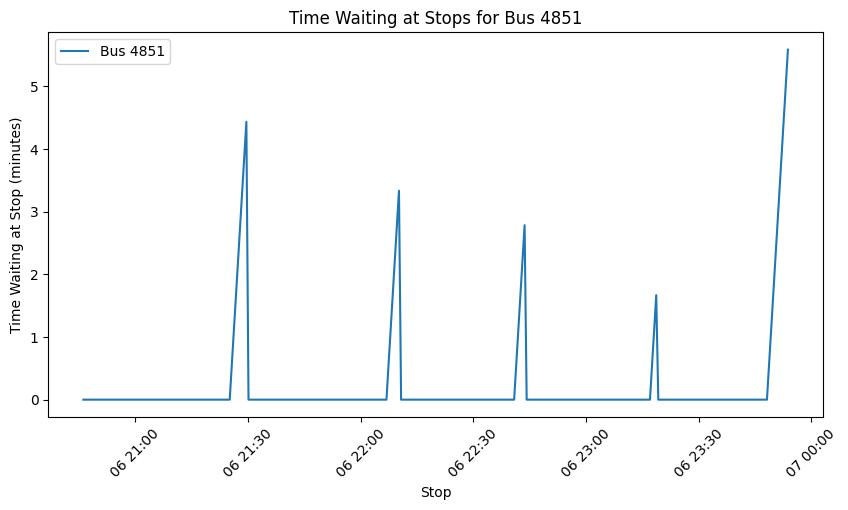

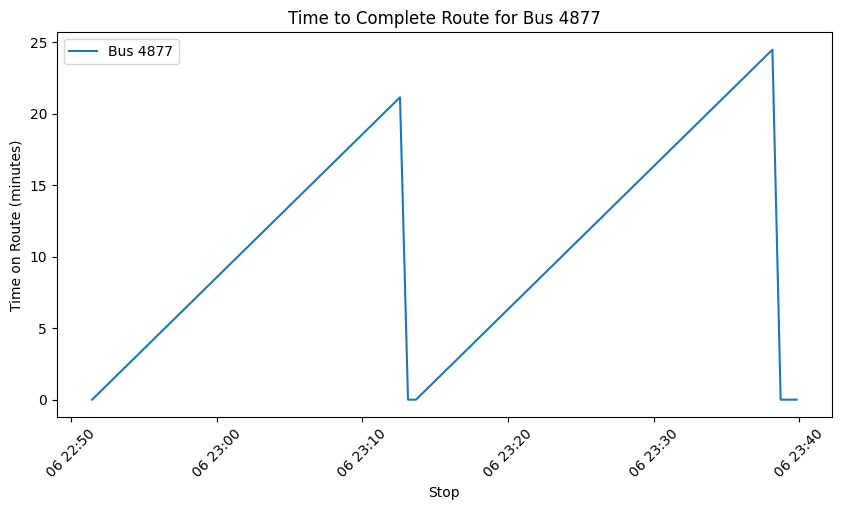

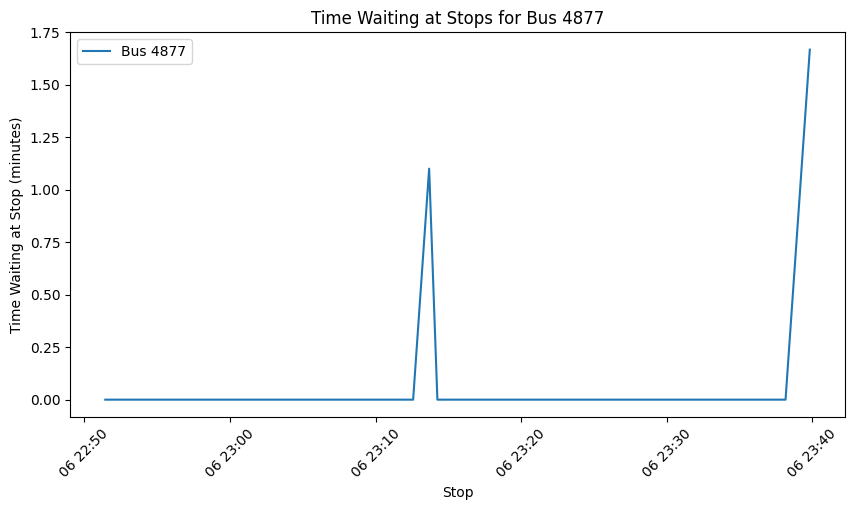

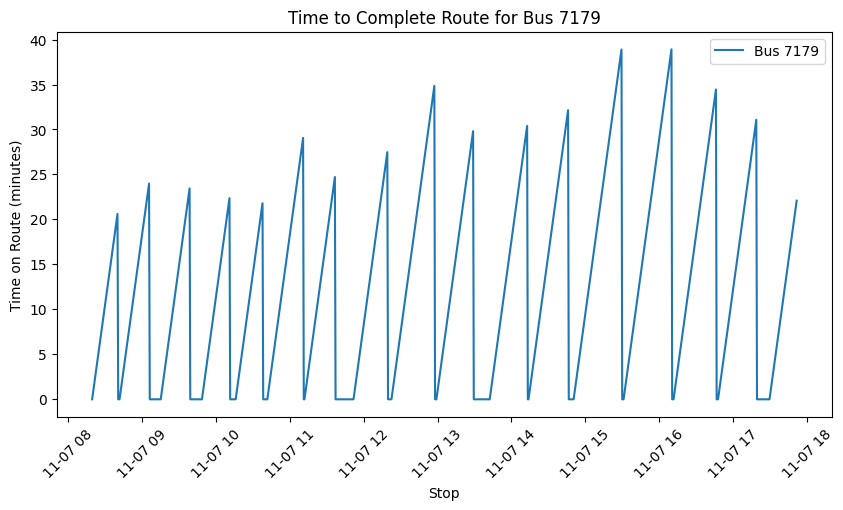

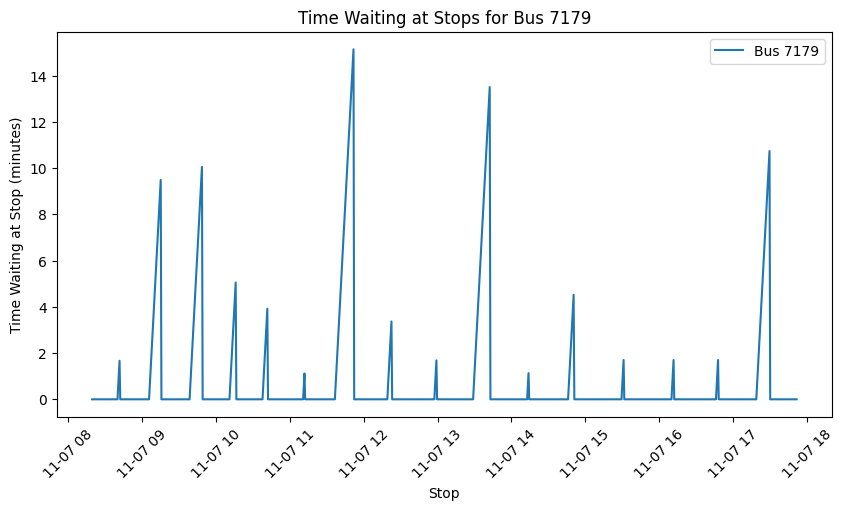

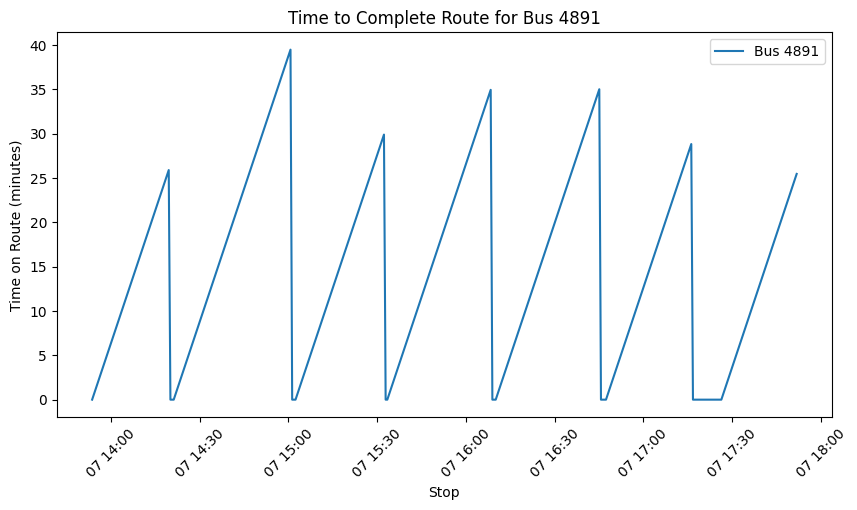

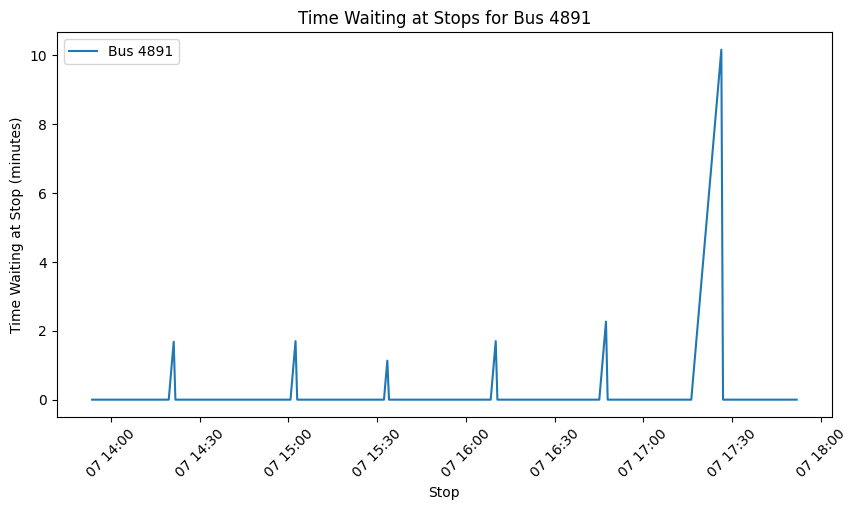

In [51]:
for bus_id in result_df['bus_id'].unique():
    bus_data = result_df[result_df['bus_id'] == bus_id]

    # Time on route plot
    plt.figure(figsize=(10, 5))
    plt.plot(bus_data['timestamp'], bus_data['time_on_route'] / 60, label=f'Bus {bus_id}')
    plt.xlabel('Stop')
    plt.ylabel('Time on Route (minutes)')
    plt.xticks(rotation=45)
    plt.title(f'Time to Complete Route for Bus {bus_id}')
    plt.legend()
    plt.show()

    # Time waiting plot
    plt.figure(figsize=(10, 5))
    plt.plot(bus_data['timestamp'], bus_data['time_waiting'] / 60, label=f'Bus {bus_id}')
    plt.xlabel('Stop')
    plt.ylabel('Time Waiting at Stop (minutes)')
    plt.xticks(rotation=45)
    plt.title(f'Time Waiting at Stops for Bus {bus_id}')
    plt.legend()
    plt.show()

In [ ]:
data_bus = data_route[data_route['id'] == 7179]
data_bus.tail()

id  name         type  calculatedCourse routeName   created  \
399395  7179   201  Transit Bus         76.099327  LX Route  04:49 PM   
399446  7179   201  Transit Bus         74.265028  LX Route  04:50 PM   
399497  7179   201  Transit Bus        346.195098  LX Route  04:50 PM   
399548  7179   201  Transit Bus         87.224197  LX Route  04:51 PM   
399599  7179   201  Transit Bus        331.011311  LX Route  04:51 PM   

        longitude   latitude  paxLoad  totalCap  more  deviceId  routeBlockId  \
399395 -74.445585  40.499649        6        67   102    405380        111422   
399446 -74.445280  40.499740        6        67   101    405380        111422   
399497 -74.445281  40.499761        6        67   101    405380        111422   
399548 -74.445259  40.499760        6        67   101    405380        111422   
399599 -74.446130  40.501636        6        67   102    405380        111422   

                 timestamp      load stop  
399395 2024-11-07 17:49:32  0.089552  NaN  
399446 2024-11-07 17:50:06  0.089552  NaN  
399497 2024-11-07 17:50:41  0.089552  NaN  
399548 2024-11-07 17:51:15  0.089552  NaN  
399599 2024-11-07 17:51:49  0.089552  NaN

In [ ]:
len(data_bus)

1020

In [ ]:
data_bus['stop'].unique()

array([nan, 'College Avenue Student Center', 'The Yard',
       'Student Activities Center (NB)', 'Livingston Plaza',
       'Livingston Student Center', 'Quads'], dtype=object)